# Enunciado
## Destino: Planeta VASS!
Por fin! El sistema que hemos creado ha terminado de analizar las características del planeta y se ha comprobado que es habitable. Después de un largo trayecto y varios inconvenientes, estamos a un paso de cumplir nuestro objetivo!

Este último paso es, probablemente, el más importante de todos, aterrizar en el planeta VASS.
Para asegurar el éxito del aterrizaje, hemos realizado una serie de experimentos en un espacio de simulación para predecir la manera más eficiente de aterrizar de forma segura.

Sin embargo, el simulador ha tenido problemas a la hora de determinar la eficiencia en algunos de los experimentos, por lo que ahora nuestro objetivo será analizar las simulaciones y determinar el nivel de eficiencia de aterrizaje de cada uno de los experimentos en los que falló. Tendremos que tener en cuenta las siguientes observaciones:

### Observaciones
- Cada uno de los experimentos cuenta con una serie pasos compuestos de estados y acciones de la nave de una simulación determinada.
- En cada paso el simulador genera un estado y decide una acción. El siguiente estado se verá determinado por esta acción, y a su vez se decidirá una nueva acción en base a ese nuevo estado, eso hasta que la simulación llegue a su fin.
- En cada paso, el simulador determina la contribución individual que ha tenido la acción tomada a la eficiencia total. Finalmente se calculan todas estas contribuciones para determinar la eficiencia total del experimento.
- La eficiencia es una función que utiliza internamente el simulador para determinar cuándo está tomando buenas decisiones. Esta función podría estar teniendo en cuenta los cambios que hay en los estados, así como las distintas acciones y variables.
- Las simulaciones se han realizado en diversas condiciones: gravedad, viento y turbulencias.
- CUIDADO! En algunas de las simulaciones los valores de la gravedad y viento no se guardaron correctamente, por lo que el sistema las ha registrado con un valor de 0.

Descarga los datos de los experimentos, analízalos y crea un modelo para predecir la eficiencia total de cada uno de los experimentos. Por último, observa los experimentos del conjunto de test que viene incluido en la descarga de los datos y envía las predicciones de los registros en el orden original separadas por comas, de la siguiente manera:

205.12,122.14,80.34,30.15,109.93

El ejemplo expuesto se correspondería con las predicciones de los 5 primeros registros, tendréis que subir en una sola línea las 2,000 predicciones usando este formato.

# How to land the Star Cruiser 42

## Context

This dataset contains information about simulations of landing a spaceship in a 2D environment.
This information can be used to determine the efficiency function in order to evaluate the best actions possible in a future landing.


## Metadata
Number of train files: 9513
Number of test files: 2000
Number of variables: 13
Target variable: efficiency


File variable details:

- x_pos # The position of the ship on the X axis, in units relative to the landing platform.
- y_pos # The position of the ship on the Y axis, in units relative to the landing platform.
- x_vel # Velocity of the ship on the X axis.
- y_vel # Velocity of the ship on the Y axis.
- angle # The angle of the spaceship in radians.
- ang_vel # The angular velocity of the spaceship.
- leg_1 # Boolean that represent whether leg 1 is in contact with the ground or not
- leg_2 # Boolean that represent whether leg 2 is in contact with the ground or not
- main_booster #  The throttle of the main engine.
- lat_booster # The throttle of the lateral boosters.

The first 6 variables determine the state and each step, and the last two (main_booster and lat_booster) are the actions taken in response
to that state, whose repercussions will be seen in the following step.

Experiment variable details:
- gravity # The magnitude of the gravity acceleration. A value of 0 means that the system didn't register the real value.
- wind_power # The maximum magnitude of linear wind applied to the spaceship. A value of 0 means that the system didn't register the real value.
- turbulences # The maximum magnitude of rotational wind applied to the spaceship.

Target variable detail
- efficiency # An internal function of the simulator to evaluate the quality of the landing.
    

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import kurtosis, skew
import math

import matplotlib.pyplot as plt
import seaborn as sns

import os, os.path
import errno

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# !mkdir data
# !unzip /content/drive/MyDrive/datos\ \fase7.zip -d /content/data/

mkdir: cannot create directory ‘data’: File exists
Archive:  /content/drive/MyDrive/datos fase7.zip
replace /content/data/experiments_summary_test.xlsx? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


# Experiments summary

In [5]:
# Open fase7/data/experiments_summary_test.xlsx and train
experiments_summary_test = pd.read_excel('data/experiments_summary_test.xlsx')
experiments_summary_train = pd.read_excel('data/experiments_summary_train.xlsx')

In [6]:
experiments_summary_train

filename  total_timesteps   gravity  wind_power  \
0         experiment_1.csv              185 -5.375066   14.337393   
1         experiment_2.csv              428 -3.958084   16.376438   
2         experiment_4.csv              193 -3.640152    1.614948   
3         experiment_5.csv              166  0.000000    0.000000   
4         experiment_6.csv              172 -5.289123   15.771525   
...                    ...              ...       ...         ...   
9508  experiment_11506.csv              290  0.000000    0.000000   
9509  experiment_11507.csv               80 -9.777887   17.290063   
9510  experiment_11508.csv              199 -5.563846   14.299549   
9511  experiment_11509.csv              115  0.000000    5.761313   
9512  experiment_11510.csv               93 -9.025862   16.478229   

      turbulence_power  efficiency  
0             1.902789      415.69  
1             1.697932      104.37  
2             0.192214      411.14  
3             0.242178      414.93  
4             1.453806      373.85  
...                ...         ...  
9508          1.734030      413.52  
9509          1.830932     -765.06  
9510          1.971660      414.10  
9511          1.203968       41.77  
9512          0.756796      323.11  

[9513 rows x 6 columns]

In [7]:
experiments_summary_test

filename  total_timesteps    gravity  wind_power  \
0         experiment_0.csv              156 -10.363594    9.555678   
1         experiment_3.csv              252  -2.599651    7.094931   
2         experiment_8.csv              146 -10.768399    5.744031   
3        experiment_10.csv              178  -7.815608   19.640269   
4        experiment_14.csv              193  -3.833533   11.007721   
...                    ...              ...        ...         ...   
1995  experiment_11478.csv              257  -5.879329   13.640501   
1996  experiment_11497.csv              845  -1.886632    0.843915   
1997  experiment_11505.csv              128   0.000000    5.633470   
1998  experiment_11511.csv              158 -10.947976    5.852086   
1999  experiment_11512.csv              153 -11.656888    9.602393   

      turbulence_power  
0             0.441689  
1             0.772004  
2             0.898704  
3             1.631348  
4             1.577970  
...                ...  
1995          0.986232  
1996          1.206717  
1997          1.822572  
1998          1.298264  
1999          1.293005  

[2000 rows x 5 columns]

In [8]:
experiments_summary_train.describe()

total_timesteps      gravity   wind_power  turbulence_power  \
count      9513.000000  9513.000000  9513.000000       9513.000000   
mean        224.807842    -5.671780     8.985153          0.998284   
std         117.874023     3.687404     6.227518          0.576618   
min          62.000000   -11.989907     0.000000          0.000089   
25%         160.000000    -8.853151     3.336993          0.503532   
50%         184.000000    -5.646706     8.888824          0.993838   
75%         244.000000    -2.633880    14.398609          1.500698   
max         996.000000     0.000000    19.996158          1.999953   

        efficiency  
count  9513.000000  
mean    365.562140  
std     201.228677  
min   -4280.660000  
25%     397.430000  
50%     407.420000  
75%     412.150000  
max     425.600000

In [9]:
experiments_summary_test.describe()

total_timesteps      gravity   wind_power  turbulence_power
count      2000.000000  2000.000000  2000.000000       2000.000000
mean        222.474000    -5.832455     8.983764          0.992948
std         118.231555     3.695817     6.208299          0.573041
min          65.000000   -11.985971     0.000000          0.001034
25%         159.000000    -9.104783     3.329954          0.486418
50%         180.000000    -6.031826     8.929544          0.985516
75%         234.000000    -2.832137    14.161360          1.484154
max         951.000000     0.000000    19.999464          1.997806

In [10]:
experiments_summary = pd.concat([experiments_summary_train, experiments_summary_test], ignore_index=True)
experiments_summary.describe()

total_timesteps       gravity    wind_power  turbulence_power  \
count     11513.000000  11513.000000  11513.000000      11513.000000   
mean        224.402415     -5.699692      8.984911          0.997357   
std         117.934382      3.689208      6.223914          0.575977   
min          62.000000    -11.989907      0.000000          0.000089   
25%         159.000000     -8.886684      3.331795          0.499894   
50%         184.000000     -5.730175      8.897582          0.993386   
75%         242.000000     -2.668897     14.352806          1.497393   
max         996.000000      0.000000     19.999464          1.999953   

        efficiency  
count  9513.000000  
mean    365.562140  
std     201.228677  
min   -4280.660000  
25%     397.430000  
50%     407.420000  
75%     412.150000  
max     425.600000

Los datos con los que vamos a trabajar son experimentos que se componen por series temporales de longitud variable. Para un experimento i, contamos con un conjunto de datos de la forma (t_j, x_j), donde t_j es el timestamp y x_j el vector de variables.

Cada experimento i cuenta con:
- gravity
- wind_power
- tubulence_power
- eficciency

El vector de variables x_j está compuesto por las variables:
- x_pos
- y_pos
- x_vel
- y_vel
- angle
- ang_vel
- leg1
- leg2
- main_booster
- lat_booster


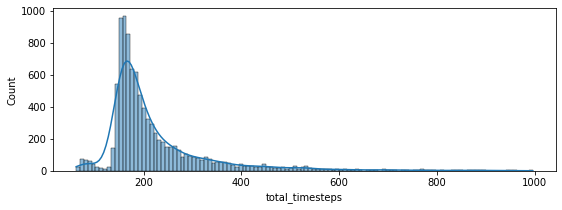

Skewness: 2.7097333474456917
Kurtosis: 9.403960196289452


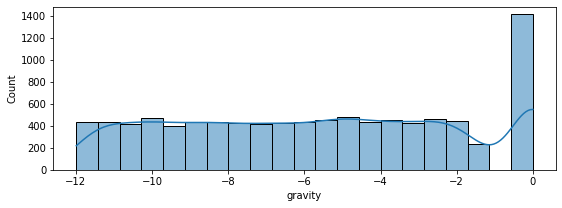

Skewness: 0.0401420069587474
Kurtosis: -1.1740127789158386


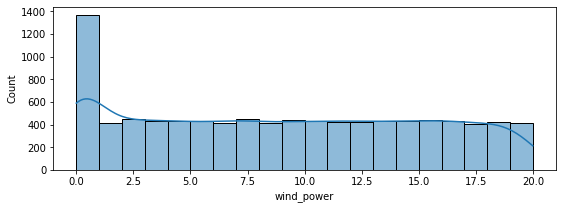

Skewness: 0.07695119224147386
Kurtosis: -1.2621910533002971


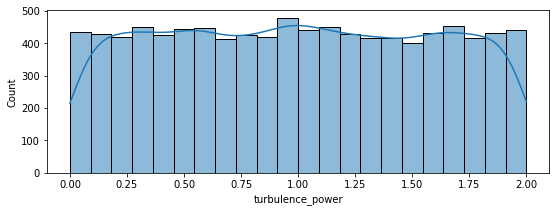

Skewness: 0.010665316623490222
Kurtosis: -1.1924621903124586


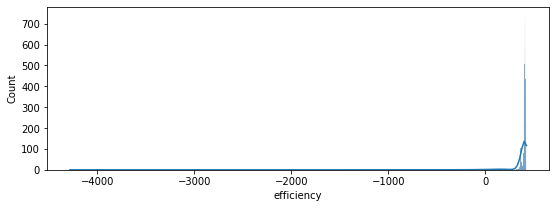

Skewness: -10.097286276431895
Kurtosis: 137.16759062025895


In [11]:
for col in experiments_summary_train.columns[1:]:
    fig = plt.figure(figsize=(9, 3))
    sns.histplot(data=experiments_summary_train, x=col, kde=True)
    plt.show()
    fig.clf()

    print('Skewness:', skew(experiments_summary_train[col]))
    print('Kurtosis:', kurtosis(experiments_summary_train[col]))

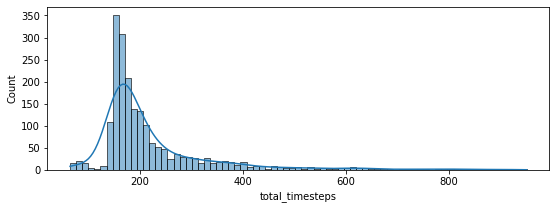

Skewness: 2.742135633358109
Kurtosis: 9.128657314846805


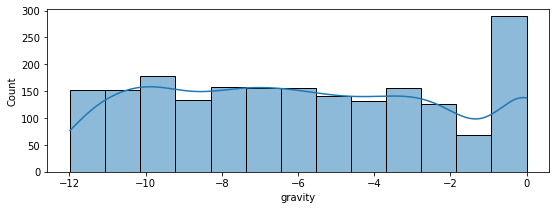

Skewness: 0.11420310856212346
Kurtosis: -1.1639227309503517


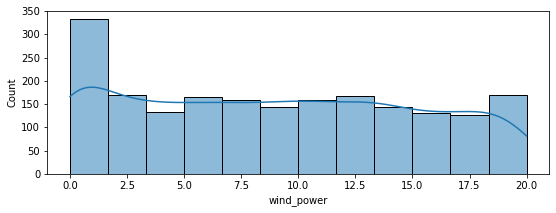

Skewness: 0.10474973690160508
Kurtosis: -1.2214878634974755


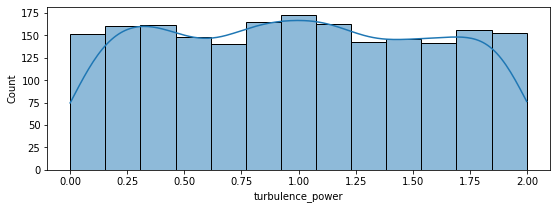

Skewness: 0.023880402596218944
Kurtosis: -1.177876908654558


In [12]:
for col in experiments_summary_test.columns[1:]:
    fig = plt.figure(figsize=(9, 3))
    sns.histplot(data=experiments_summary_test, x=col, kde=True)
    plt.show()
    fig.clf()

    print('Skewness:', skew(experiments_summary_test[col]))
    print('Kurtosis:', kurtosis(experiments_summary_test[col]))

In [13]:
for q in range(100):
    if np.percentile(experiments_summary_train['efficiency'], q) >= 0:
        print(q)
        break

3


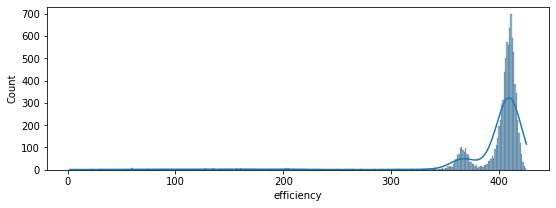

In [14]:
fig = plt.figure(figsize=(9, 3))
sns.histplot(data=experiments_summary_train[experiments_summary_train['efficiency'] > 0], x='efficiency', kde=True)
plt.show()
fig.clf()

In [15]:
for q in range(100):
    if np.percentile(experiments_summary_train['efficiency'], q) >= 350:
        print(q)
        break

9


Los dos conjuntos siguen la misma distribución para las variables como es de esperar, además de contar con los outliers comentados en el enunciado del ejercicio correspondientes al valor 0 para las variables gravity y wind_power.

Para la variable total_timesteps, podemos ver que aunque el 75% de las entradas tiene de un valor aproximadamente menor a 240 existen entradas que se extienden hasta los 900. 

Para la variable total_timesteps podemos ver que el 75% de las series cuenta con un timestamp menor a 242. El resto de casos se tratan de outliers, es decir, experimentos para los que el aterrizaje ha necesitado más tiempo. Esta variable se trata de una distribución de cola larga sesgada a la derecha.

Para las variables gravity y wind_power siguen una distribución uniforme, a excepción de las entradas con valor 0 para estas variables ya que se tratan de valores no registrados por el sistema.

Para la variable efficiency se observa una distribución de cola larga muy sesgada a la izquierda. El 3% de las entradas cuenta con un valor negativo para efficiency, por lo que la mayoría de entradas cuentan con un valor positivo para la variable. Además, un 91% de estas se encuentran entre 350 y 425.6.

In [16]:
def get_nans_experiments_summary(experiments_summary):
    gravity_nans = (experiments_summary['gravity'] == 0).sum()
    wind_power_nans = (experiments_summary['wind_power'] == 0).sum()
    gravity_wind_power_nans = ((experiments_summary[['gravity', 'wind_power']] == 0).sum(axis=1) == 2).sum()

    return gravity_nans, wind_power_nans, gravity_wind_power_nans

In [17]:
print(get_nans_experiments_summary(experiments_summary_train))
print(get_nans_experiments_summary(experiments_summary_test))

(1412, 948, 133)
(289, 190, 23)


# Experiments' series

In [18]:
def get_nans_experiments_series(series_path):
    nans_experiments = dict()

    for filename in os.listdir(series_path):
        series_file = os.path.join(series_path, filename)
        experiment_series = pd.read_csv(series_file)

        nans_experiments[filename] = experiment_series.isnull().sum().sum()

    nans_experiments = pd.DataFrame.from_dict(nans_experiments, orient='index')
    nans_experiments = nans_experiments.reset_index()
    nans_experiments.columns = ['experiment', 'nans']
    return nans_experiments

In [19]:
train_series_path = 'data/train'
test_series_path = 'data/test'

train_series_nans = get_nans_experiments_series(train_series_path)
test_series_nans = get_nans_experiments_series(test_series_path)

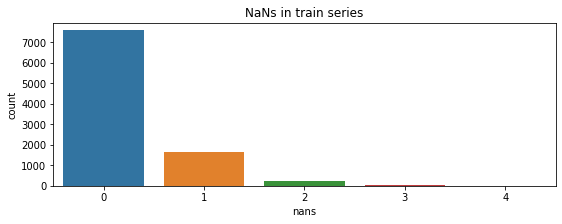

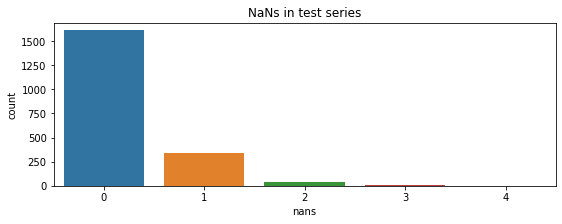

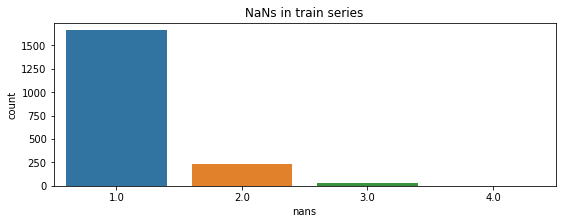

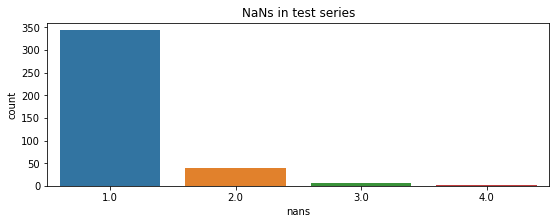

In [20]:
fig = plt.figure(figsize=(9, 3))
sns.countplot(data=train_series_nans, x='nans')
plt.title('NaNs in train series')
plt.show()
fig.clf()

fig = plt.figure(figsize=(9, 3))
sns.countplot(data=test_series_nans, x='nans')
plt.title('NaNs in test series')
plt.show()
fig.clf()

fig = plt.figure(figsize=(9, 3))
sns.countplot(data=train_series_nans[-(train_series_nans == 0)], x='nans')
plt.title('NaNs in train series')
plt.show()
fig.clf()

fig = plt.figure(figsize=(9, 3))
sns.countplot(data=test_series_nans[-(test_series_nans == 0)], x='nans')
plt.title('NaNs in test series')
plt.show()
fig.clf()

In [21]:
train_experiments_summary_path = 'data/experiments_summary_train.xlsx'
test_experiments_summary_path = 'data/experiments_summary_test.xlsx'

In [22]:
def get_serie_describe(serie):
    serie_describe = serie.describe().drop(columns=['leg_1', 'leg_2'])
    serie_describe = serie_describe.transpose().drop(columns=['count'])

    values = dict()

    for index, row in serie_describe.iterrows():
        for col in row.index:
            values[f'{index}_{col}'] = row[col]

    return values


def get_experiments_stats(series_path):
    
    experiments_stats = dict()

    for filename in os.listdir(series_path):
        series_file = os.path.join(series_path, filename)
        experiment_series = pd.read_csv(series_file)

        experiments_stats[filename] = get_serie_describe(experiment_series)

        experiments_stats[filename] = {**experiments_stats[filename],
            'x0_pos': experiment_series.iloc[0]['x_pos'],
            'y0_pos': experiment_series.iloc[0]['y_pos'],
            'xf_pos': experiment_series.iloc[-1]['x_pos'],
            'yf_pos': experiment_series.iloc[-1]['y_pos'],
            'total_main_booster': experiment_series['main_booster'].abs().sum(),
            'total_lat_booster': experiment_series['lat_booster'].abs().sum(),
            'legs': experiment_series.iloc[-1]['leg_1'] + experiment_series.iloc[-1]['leg_2'],
            'total_dist': experiment_series[['x_pos', 'y_pos']].apply(lambda row: np.sqrt(row[0]**2 + row[1]**2), axis=1).sum(),
            'initial_end_dist': np.linalg.norm(experiment_series.iloc[0][['x_pos', 'y_pos']] - experiment_series.iloc[-1][['x_pos', 'y_pos']])
        }

    experiments_stats = pd.DataFrame.from_dict(experiments_stats, orient='index')
    experiments_stats = experiments_stats.reset_index()
    columns = ['filename'] + experiments_stats.columns[1:].tolist()
    experiments_stats.columns = columns
    return experiments_stats

In [23]:
experiments_summary_train_stats = get_experiments_stats(train_series_path)
experiments_summary_test_stats = get_experiments_stats(test_series_path)

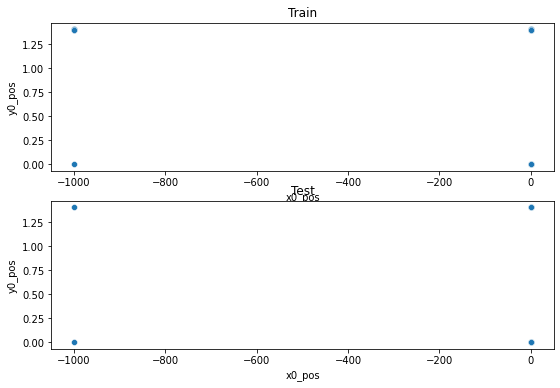

In [24]:
fig = plt.figure(figsize=(9, 6))
ax1 = fig.add_subplot(211)
sns.scatterplot(data=experiments_summary_train_stats, x='x0_pos', y='y0_pos')
plt.title('Train')

ax2 = fig.add_subplot(212)
sns.scatterplot(data=experiments_summary_test_stats, x='x0_pos', y='y0_pos')
plt.title('Test')
plt.show()

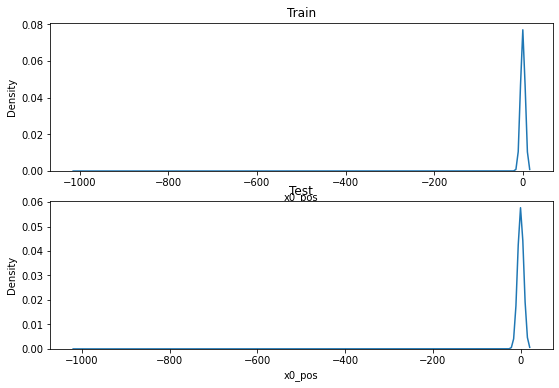

In [25]:
fig = plt.figure(figsize=(9, 6))
ax1 = fig.add_subplot(211)
sns.kdeplot(data=experiments_summary_train_stats, x='x0_pos')
plt.title('Train')

ax2 = fig.add_subplot(212)
sns.kdeplot(data=experiments_summary_test_stats, x='x0_pos')
plt.title('Test')
plt.show()

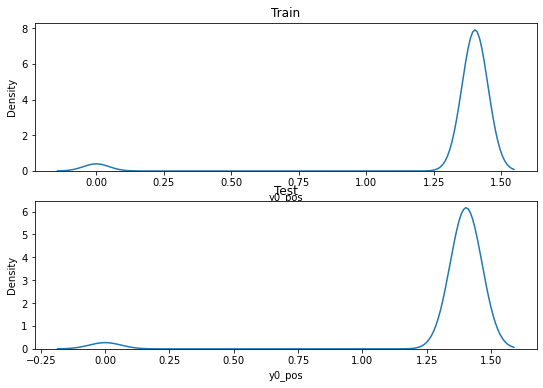

In [26]:
fig = plt.figure(figsize=(9, 6))
ax1 = fig.add_subplot(211)
sns.kdeplot(data=experiments_summary_train_stats, x='y0_pos')
plt.title('Train')

ax2 = fig.add_subplot(212)
sns.kdeplot(data=experiments_summary_test_stats, x='y0_pos')
plt.title('Test')
plt.show()

En cuanto a las posiciones iniciales de los experimentos, podemos ver que existen valores atípicos con valor -999 para la variable x_pos que analizaremos ya que podrían tratarse de errores o outliers que deberemos tratar.

Para la variable y_pos no se encuentra ningún comportamiento atípico.

In [27]:
experiments_summary_train_stats[experiments_summary_train_stats['x0_pos']==-999]

filename  x_pos_mean  x_pos_std  x_pos_min  x_pos_25%  \
799   experiment_1398.csv   -6.561016  80.761794     -999.0  -0.052361   
1480  experiment_3736.csv   -5.420653  73.048375     -999.0  -0.140814   
1743  experiment_8436.csv   -5.357227  72.468370     -999.0  -0.137361   
1820  experiment_9367.csv   -5.868992  75.945375     -999.0  -0.168423   
3540  experiment_6713.csv   -2.363955  46.981827     -999.0  -0.231467   
5335  experiment_3950.csv   -5.320488  73.055723     -999.0  -0.016423   
6504  experiment_8107.csv   -1.561733  39.771215     -999.0  -0.158754   
8302  experiment_6825.csv   -4.296020  65.731290     -999.0  -0.015964   
8343  experiment_8606.csv   -4.810354  69.606384     -999.0  -0.006368   
8535    experiment_91.csv   -5.804497  75.729188     -999.0  -0.092864   

      x_pos_50%  x_pos_75%  x_pos_max  y_pos_mean  y_pos_std  ...  \
799   -0.028202  -0.010770  -0.002962    0.461987   0.481225  ...   
1480  -0.076336  -0.015647  -0.003345    0.440866   0.448486  ...   
1743  -0.115706  -0.007891   0.039310    0.269464   0.445389  ...   
1820  -0.076612  -0.023804  -0.003298    0.466844   0.480795  ...   
3540  -0.171510  -0.066596  -0.003007    0.669481   0.492739  ...   
5335   0.028846   0.057998   0.061730    0.448416   0.493379  ...   
6504   0.077040   0.194814   0.423266    0.858901   0.656403  ...   
8302   0.011191   0.083474   0.114386    0.544881   0.486373  ...   
8343   0.032350   0.084543   0.107169    0.563099   0.508371  ...   
8535  -0.058234  -0.038952  -0.003170    0.474091   0.478740  ...   

      lat_booster_max  x0_pos    y0_pos    xf_pos    yf_pos  \
799          0.858888  -999.0  1.403033 -0.009327 -0.000471   
1480         0.981488  -999.0  0.000000 -0.004230 -0.000509   
1743         0.998776  -999.0  1.403426 -0.112047  0.000814   
1820         0.999490  -999.0  1.403033 -0.022547 -0.000462   
3540         0.971965  -999.0  1.403504 -0.055563 -0.000729   
5335         0.997181  -999.0  1.403446  0.057998 -0.000753   
6504         0.999986  -999.0  1.403325  0.138497 -0.000783   
8302         0.998567  -999.0  1.403366 -0.035563 -0.001033   
8343         0.998078  -999.0  1.403269 -0.014644 -0.001227   
8535         0.993104  -999.0  1.403122 -0.038951 -0.000274   

      total_main_booster  total_lat_booster  legs   total_dist  \
799            75.204709          56.833225   2.0  1069.028339   
1480          103.591852          85.555736   2.0  1084.500031   
1743          231.463905         145.738481   1.0  2130.062188   
1820           99.581779         112.971144   2.0  1082.956695   
3540          285.657137         184.545952   2.0  1316.381428   
5335          119.733423          59.919256   2.0  1085.394517   
6504          299.287683         371.695271   2.0  1581.355241   
8302          137.705192         116.688369   2.0  1126.071887   
8343          121.739191         105.605696   2.0  1115.103040   
8535           81.004719          73.734146   2.0  1083.332879   

      initial_end_dist  
799         998.991659  
1480        998.995770  
1743        998.888938  
1820        998.978439  
3540        998.945424  
5335        999.058985  
6504        999.139484  
8302        998.965424  
8343        998.986344  
8535        998.962034  

[10 rows x 66 columns]

In [28]:
experiments_summary_test_stats[experiments_summary_test_stats['x0_pos']==-999]

filename  x_pos_mean  x_pos_std  x_pos_min  x_pos_25%  \
171   experiment_7602.csv   -5.304005  72.665220     -999.0  -0.025753   
1753  experiment_5577.csv   -3.919794  60.783895     -999.0  -0.344207   

      x_pos_50%  x_pos_75%  x_pos_max  y_pos_mean  y_pos_std  ...  \
171   -0.017522  -0.011792  -0.003123    0.522059   0.506181  ...   
1753  -0.206022  -0.112143  -0.003360    0.520538   0.472616  ...   

      lat_booster_max  x0_pos    y0_pos    xf_pos    yf_pos  \
171          0.999829  -999.0  0.000000 -0.017522 -0.000989   
1753         0.999923  -999.0  1.403297 -0.110744 -0.000443   

      total_main_booster  total_lat_booster  legs   total_dist  \
171           100.589018          85.838727   2.0  1098.636971   
1753          123.645831         137.595149   1.0  1162.292026   

      initial_end_dist  
171         998.982478  
1753        998.890242  

[2 rows x 66 columns]

Se puede apreciar en los casos de entrenamiento que a pesar de comenzar en valores que consideramos como atípicos, en todos los casos la variable efficiency alcanza valores elevados.

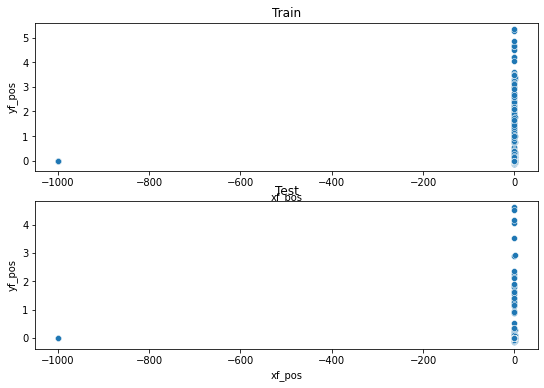

In [29]:
fig = plt.figure(figsize=(9, 6))
ax1 = fig.add_subplot(211)
sns.scatterplot(data=experiments_summary_train_stats, x='xf_pos', y='yf_pos')
plt.title('Train')

ax2 = fig.add_subplot(212)
sns.scatterplot(data=experiments_summary_test_stats, x='xf_pos', y='yf_pos')
plt.title('Test')
plt.show()

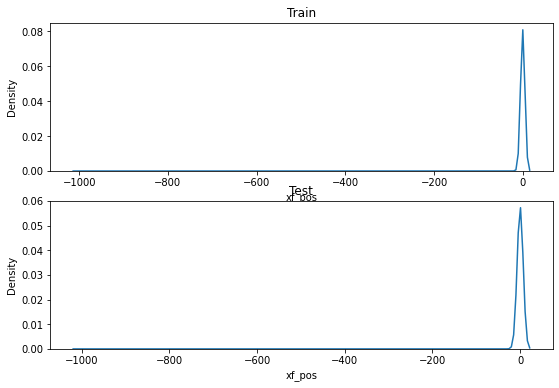

In [30]:
fig = plt.figure(figsize=(9, 6))
ax1 = fig.add_subplot(211)
sns.kdeplot(data=experiments_summary_train_stats, x='xf_pos')
plt.title('Train')

ax2 = fig.add_subplot(212)
sns.kdeplot(data=experiments_summary_test_stats, x='xf_pos')
plt.title('Test')
plt.show()

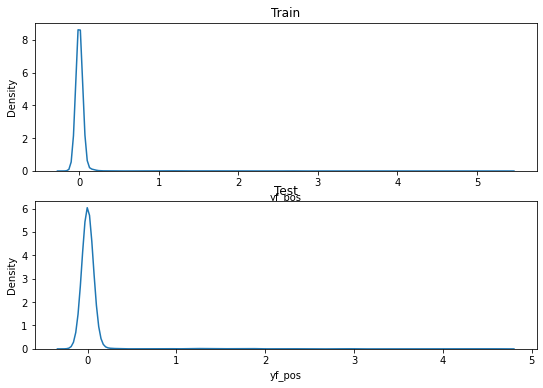

In [31]:
fig = plt.figure(figsize=(9, 6))
ax1 = fig.add_subplot(211)
sns.kdeplot(data=experiments_summary_train_stats, x='yf_pos')
plt.title('Train')

ax2 = fig.add_subplot(212)
sns.kdeplot(data=experiments_summary_test_stats, x='yf_pos')
plt.title('Test')
plt.show()

In [32]:
experiments_summary_train_stats[experiments_summary_train_stats['xf_pos']==-999]

filename  x_pos_mean   x_pos_std  x_pos_min  x_pos_25%  \
783   experiment_8725.csv   -6.438633   80.242144     -999.0  -0.025338   
908   experiment_5690.csv   -2.362232   47.675559     -999.0  -0.132720   
952   experiment_4527.csv   -5.664604   74.662491     -999.0  -0.114408   
3418  experiment_7984.csv   -2.140220   43.179262     -999.0  -0.440144   
3522  experiment_7132.csv  -11.581802  107.096914     -999.0  -0.097872   
3898  experiment_2226.csv  -12.024640  109.659837     -999.0   0.047531   
4242  experiment_2879.csv   -3.246897   55.234297     -999.0  -0.305401   
5532  experiment_7354.csv   -9.141872   94.809292     -999.0  -0.204447   
6905  experiment_4930.csv   -9.797753   98.917797     -999.0  -0.005873   

      x_pos_50%  x_pos_75%  x_pos_max  y_pos_mean  y_pos_std  ...  \
783    0.010651   0.035293   0.042520    0.442508   0.490519  ...   
908   -0.081945  -0.043197   0.005429    0.500694   0.506121  ...   
952   -0.088166  -0.059851  -0.001546    0.440604   0.489667  ...   
3418  -0.159855  -0.122255  -0.001480    0.561739   0.543909  ...   
3522  -0.015419   0.019075   0.043045    0.473481   0.499299  ...   
3898   0.091113   0.125809   0.146419    0.355080   0.450617  ...   
4242  -0.198842  -0.077091  -0.001556    0.565133   0.412611  ...   
5532  -0.093359  -0.008896   0.016374    0.420975   0.447263  ...   
6905   0.070397   0.081514   0.088328    0.428311   0.476775  ...   

      lat_booster_max    x0_pos    y0_pos  xf_pos    yf_pos  \
783          0.973926 -0.001547  1.403058  -999.0 -0.000845   
908          0.999632 -0.001528  1.403519  -999.0 -0.000552   
952          0.937446 -0.001546  1.403293  -999.0 -0.000532   
3418         0.996267 -0.001480  1.403462  -999.0 -0.000268   
3522         0.999645 -0.001421  1.403206  -999.0 -0.000710   
3898         0.990468 -0.001382  1.403028  -999.0 -0.001111   
4242         0.998952 -0.001556  1.403473  -999.0 -0.000650   
5532         0.991845 -0.001600  1.403268  -999.0 -0.000927   
6905         0.936436 -0.001479  1.403466  -999.0 -0.000721   

      total_main_booster  total_lat_booster  legs   total_dist  \
783            92.987515          77.180502   2.0  1069.560397   
908           296.358374         207.747416   2.0  1230.572990   
952            97.271657          70.312953   2.0  1085.939655   
3418          295.071568         222.335705   1.0  1359.179324   
3522           98.800987          99.676267   2.0  2084.701654   
3898          103.927484          67.425323   1.0  2064.700388   
4242          181.143620         130.887295   2.0  1201.323429   
5532          110.399544         122.944405   2.0  2097.425338   
6905          122.496863          72.534004   2.0  2090.955695   

      initial_end_dist  
783         998.999439  
908         998.999458  
952         998.999440  
3418        998.999507  
3522        998.999565  
3898        998.999604  
4242        998.999430  
5532        998.999387  
6905        998.999508  

[9 rows x 66 columns]

In [33]:
experiments_summary_test_stats[experiments_summary_test_stats['xf_pos']==-999]

filename  x_pos_mean  x_pos_std  x_pos_min  x_pos_25%  \
851   experiment_6191.csv   -8.981981  93.966485     -999.0  -0.158021   
1362  experiment_9411.csv   -3.766585  60.344545     -999.0  -0.214384   

      x_pos_50%  x_pos_75%  x_pos_max  y_pos_mean  y_pos_std  ...  \
851   -0.101062  -0.057764  -0.001550    0.569282   0.502022  ...   
1362  -0.109022  -0.033515  -0.001544    0.383032   0.440641  ...   

      lat_booster_max    x0_pos    y0_pos  xf_pos    yf_pos  \
851          0.994885 -0.001550  1.403207  -999.0 -0.001050   
1362         0.998850 -0.001544  1.403264  -999.0 -0.000279   

      total_main_booster  total_lat_booster  legs   total_dist  \
851           134.889893         102.076130   2.0  2132.916775   
1362          162.870803         129.755929   1.0  1117.139578   

      initial_end_dist  
851         998.999437  
1362        998.999442  

[2 rows x 66 columns]

Para las posiciones finales encontramos el mismo comportamiento que para las posiciones iniciales. Cabe destacar que no se producen casos en los que se tenga una x_pos inicial de -999 y se finalice en la misma posición.

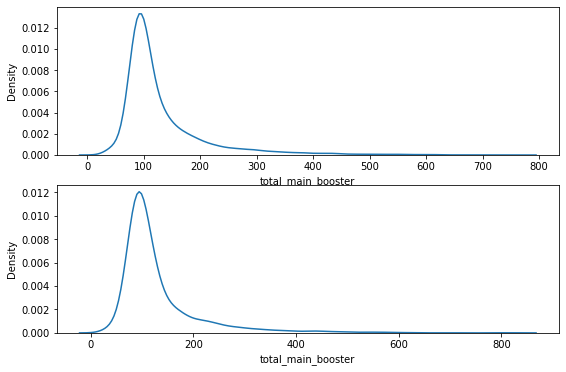

In [34]:
fig = plt.figure(figsize=(9, 6))
ax1 = fig.add_subplot(211)
sns.kdeplot(data=experiments_summary_train_stats, x='total_main_booster')

ax2 = fig.add_subplot(212)
sns.kdeplot(data=experiments_summary_test_stats, x='total_main_booster')
plt.show()

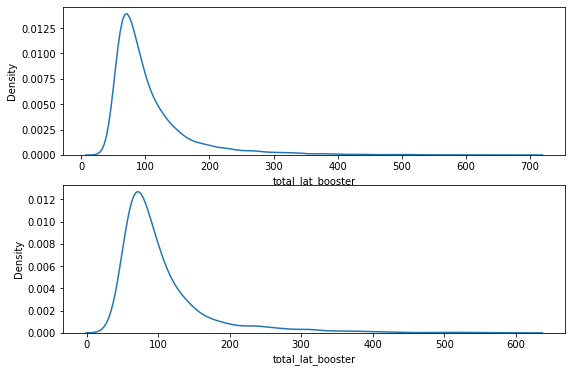

In [35]:
fig = plt.figure(figsize=(9, 6))
ax1 = fig.add_subplot(211)
sns.kdeplot(data=experiments_summary_train_stats, x='total_lat_booster')

ax2 = fig.add_subplot(212)
sns.kdeplot(data=experiments_summary_test_stats, x='total_lat_booster')
plt.show()

In [36]:
legs_percentage_train_experiments = experiments_summary_train_stats['legs'].value_counts()/experiments_summary_train_stats['legs'].value_counts().sum() * 100
legs_percentage_test_experiments = experiments_summary_test_stats['legs'].value_counts()/experiments_summary_test_stats['legs'].value_counts().sum() * 100

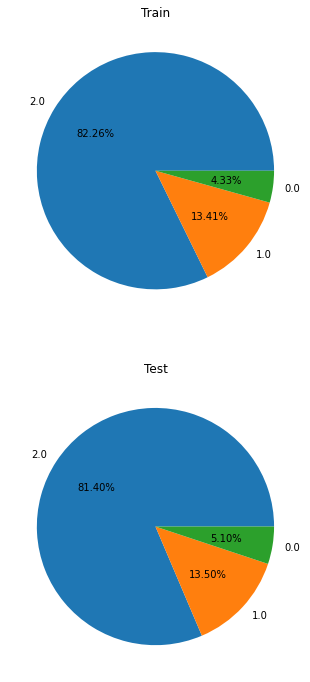

In [37]:
fig = plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(211)
plt.pie(legs_percentage_train_experiments.values, labels=legs_percentage_train_experiments.index.values, autopct='%0.2f%%')
plt.title('Train')

ax2 = fig.add_subplot(212)
plt.pie(legs_percentage_test_experiments.values, labels=legs_percentage_test_experiments.index.values, autopct='%0.2f%%')
plt.title('Test')
plt.show()

En cuanto al número de patas (legs) de la nave apoyadas al final de los experimentos, se puede observar como para ambos conjuntos alrededor de un 80% de los experimentos finaliza con ambas patas en tierra. Estos se tratan de aterrizajes exitosos, independientemente del valor de efficiency obtenido. Sería interesante estudiar si existe alguna relación entre estos resultados y el valor de la variable target efficiency.

In [38]:
full_experiments_summary_train = experiments_summary_train.merge(experiments_summary_train_stats, on='filename')
full_experiments_summary_test = experiments_summary_test.merge(experiments_summary_test_stats, on='filename')

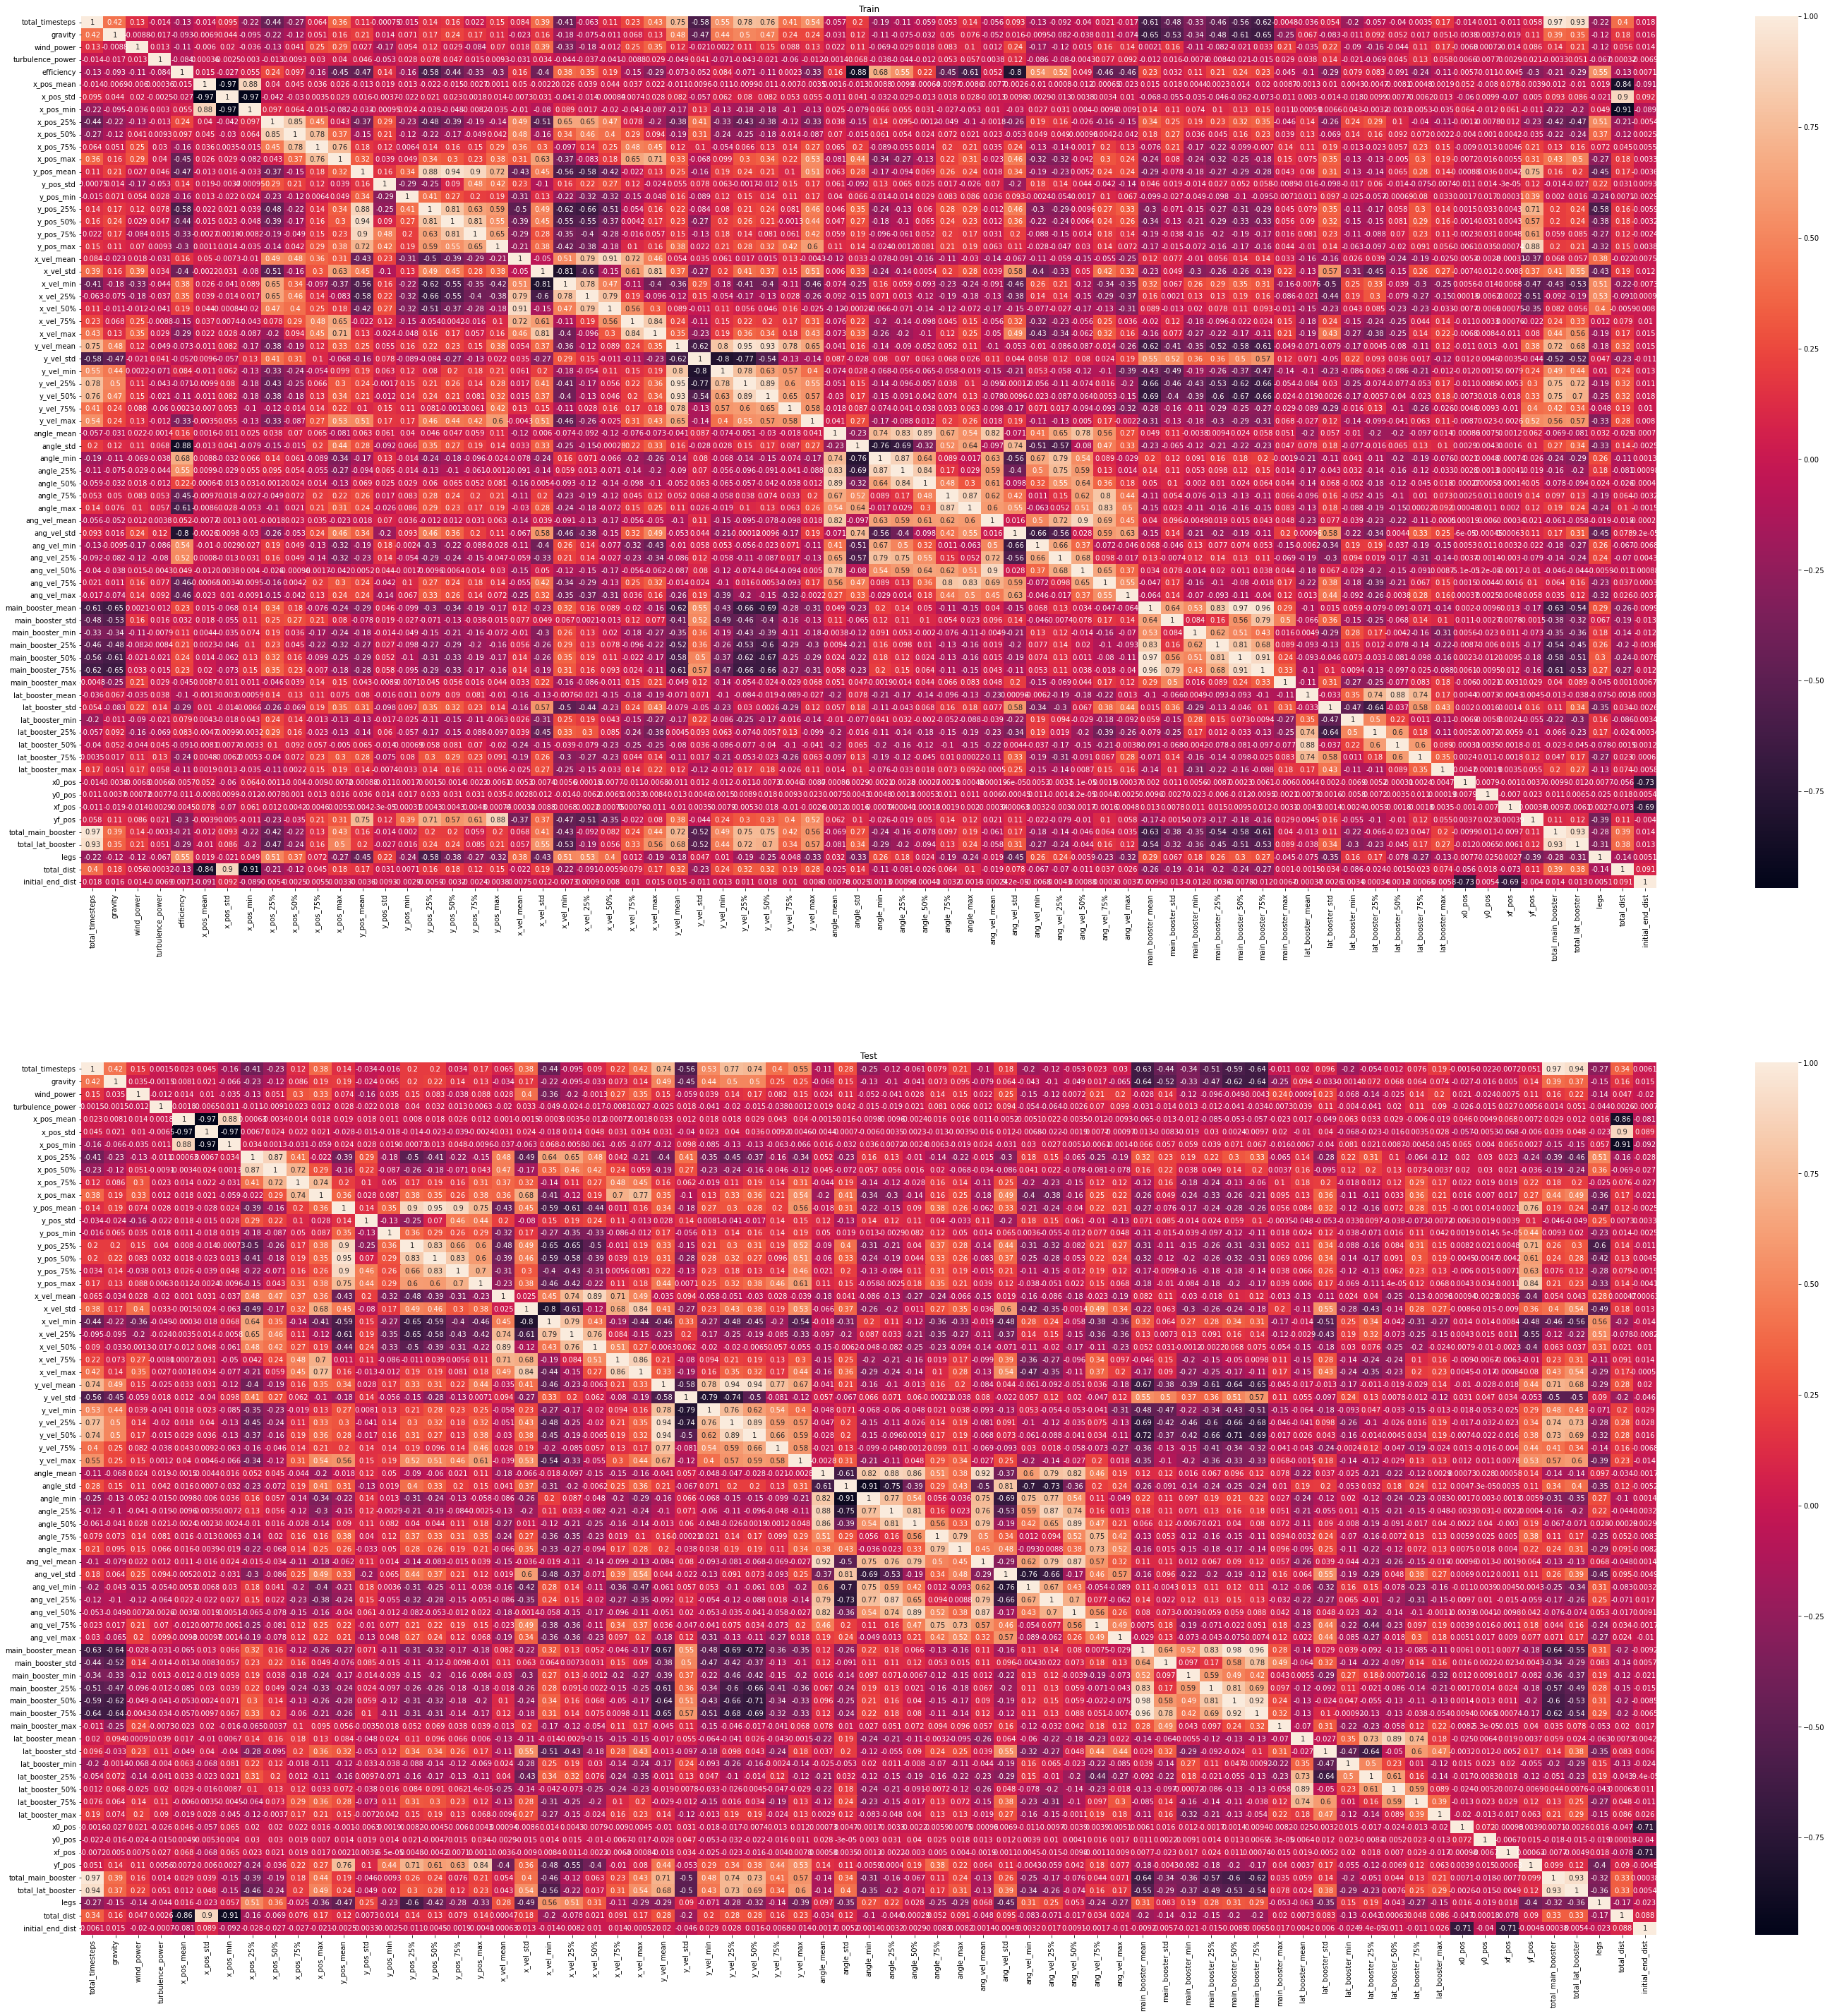

In [39]:
fig = plt.figure(figsize=(50, 50))
ax1 = fig.add_subplot(211)
sns.heatmap(full_experiments_summary_train.corr(), annot=True)
plt.title('Train')

ax2 = fig.add_subplot(212)
sns.heatmap(full_experiments_summary_test.corr(), annot=True)
plt.title('Test')
plt.show()

In [40]:
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale

In [41]:
def plot_explained_variance(dataset, pca_model):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(25, 25))
    ax.bar(
        x      = np.arange(pca_model.n_components_) + 1,
        height = pca_model.explained_variance_ratio_
    )

    for x, y in zip(np.arange(len(dataset.columns)) + 1, pca_model.explained_variance_ratio_):
        label = round(y, 2)
        ax.annotate(
            label,
            (x,y),
            textcoords="offset points",
            xytext=(0,10),
            ha='center'
        )

    ax.set_xticks(np.arange(pca_model.n_components_) + 1)
    ax.set_ylim(0, 1.1)
    ax.set_title('Explained variance percentage per principal component')
    ax.set_xlabel('Principal component')
    ax.set_ylabel('Percent. explained variance')
    plt.show()

    return fig, ax

def plot_explained_variance_ratio(dataset, pca_model):
    prop_varianza_acum = pca_model.explained_variance_ratio_.cumsum()

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(25, 25))
    ax.plot(
        np.arange(len(dataset.columns)) + 1,
        prop_varianza_acum,
        marker = 'o'
    )

    for x, y in zip(np.arange(len(dataset.columns)) + 1, prop_varianza_acum):
        label = round(y, 2)
        ax.annotate(
            label,
            (x,y),
            textcoords="offset points",
            xytext=(0,10),
            ha='center'
        )
        
    ax.set_ylim(0, 1.1)
    ax.set_xticks(np.arange(pca_model.n_components_) + 1)
    ax.set_title('Cumulative explained variance percentage per principal component')
    ax.set_xlabel('Principal component')
    ax.set_ylabel('percent. cumulative explained variance')
    plt.show()

    return fig, ax

def plot_variable_importance(dataset, pca_model):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(25, 25))
    componentes = pca_model.components_
    plt.imshow(componentes.T, cmap='magma', aspect='auto')
    plt.yticks(range(len(dataset.columns)), dataset.columns)
    plt.xticks(range(len(dataset.columns)), np.arange(pca_model.n_components_) + 1)
    plt.grid(False)
    plt.colorbar()
    plt.show()

    return fig, ax

In [42]:
pca_train_pipe = make_pipeline(StandardScaler(), PCA())
pca_train_pipe.fit(full_experiments_summary_train.loc[:, full_experiments_summary_train.columns != 'filename'])

train_pca_model = pca_train_pipe.named_steps['pca']

pca_test_pipe = make_pipeline(StandardScaler(), PCA())
pca_test_pipe.fit(full_experiments_summary_test.loc[:, full_experiments_summary_test.columns != 'filename'])

test_pca_model = pca_test_pipe.named_steps['pca']

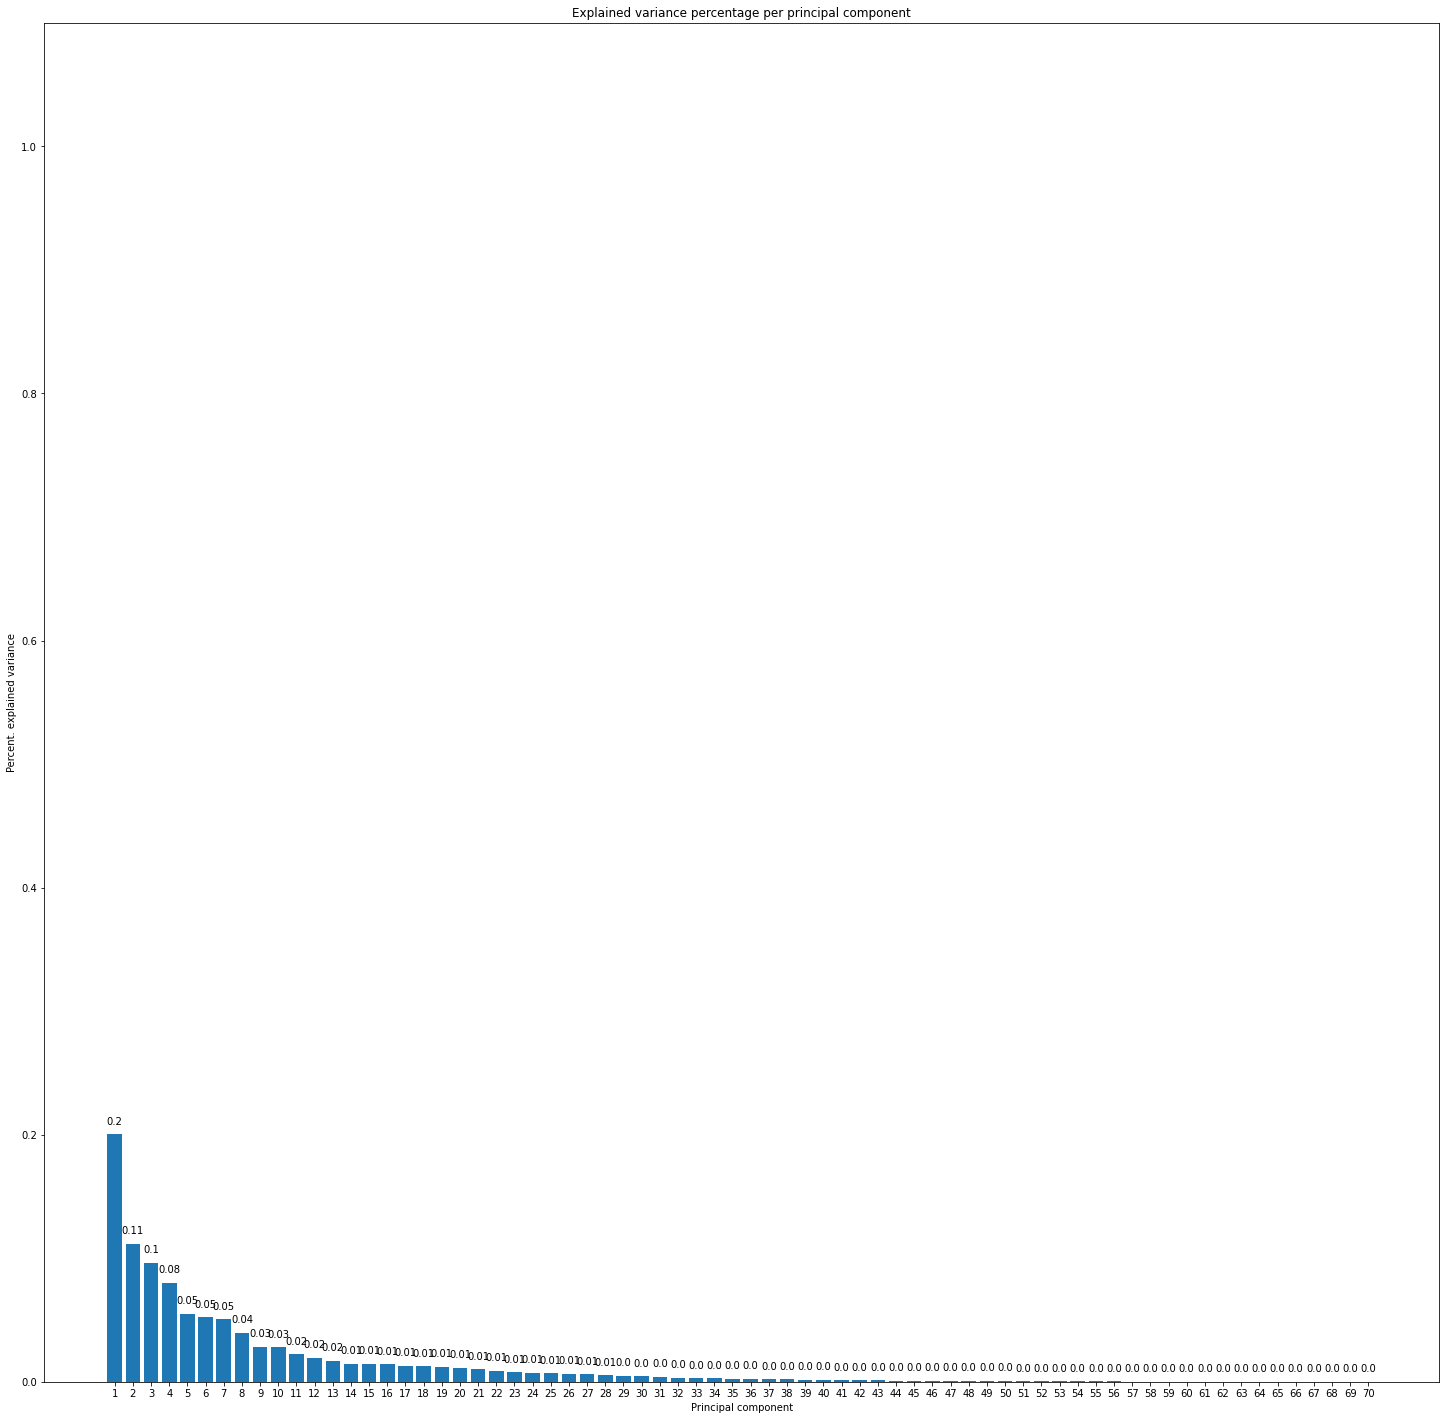

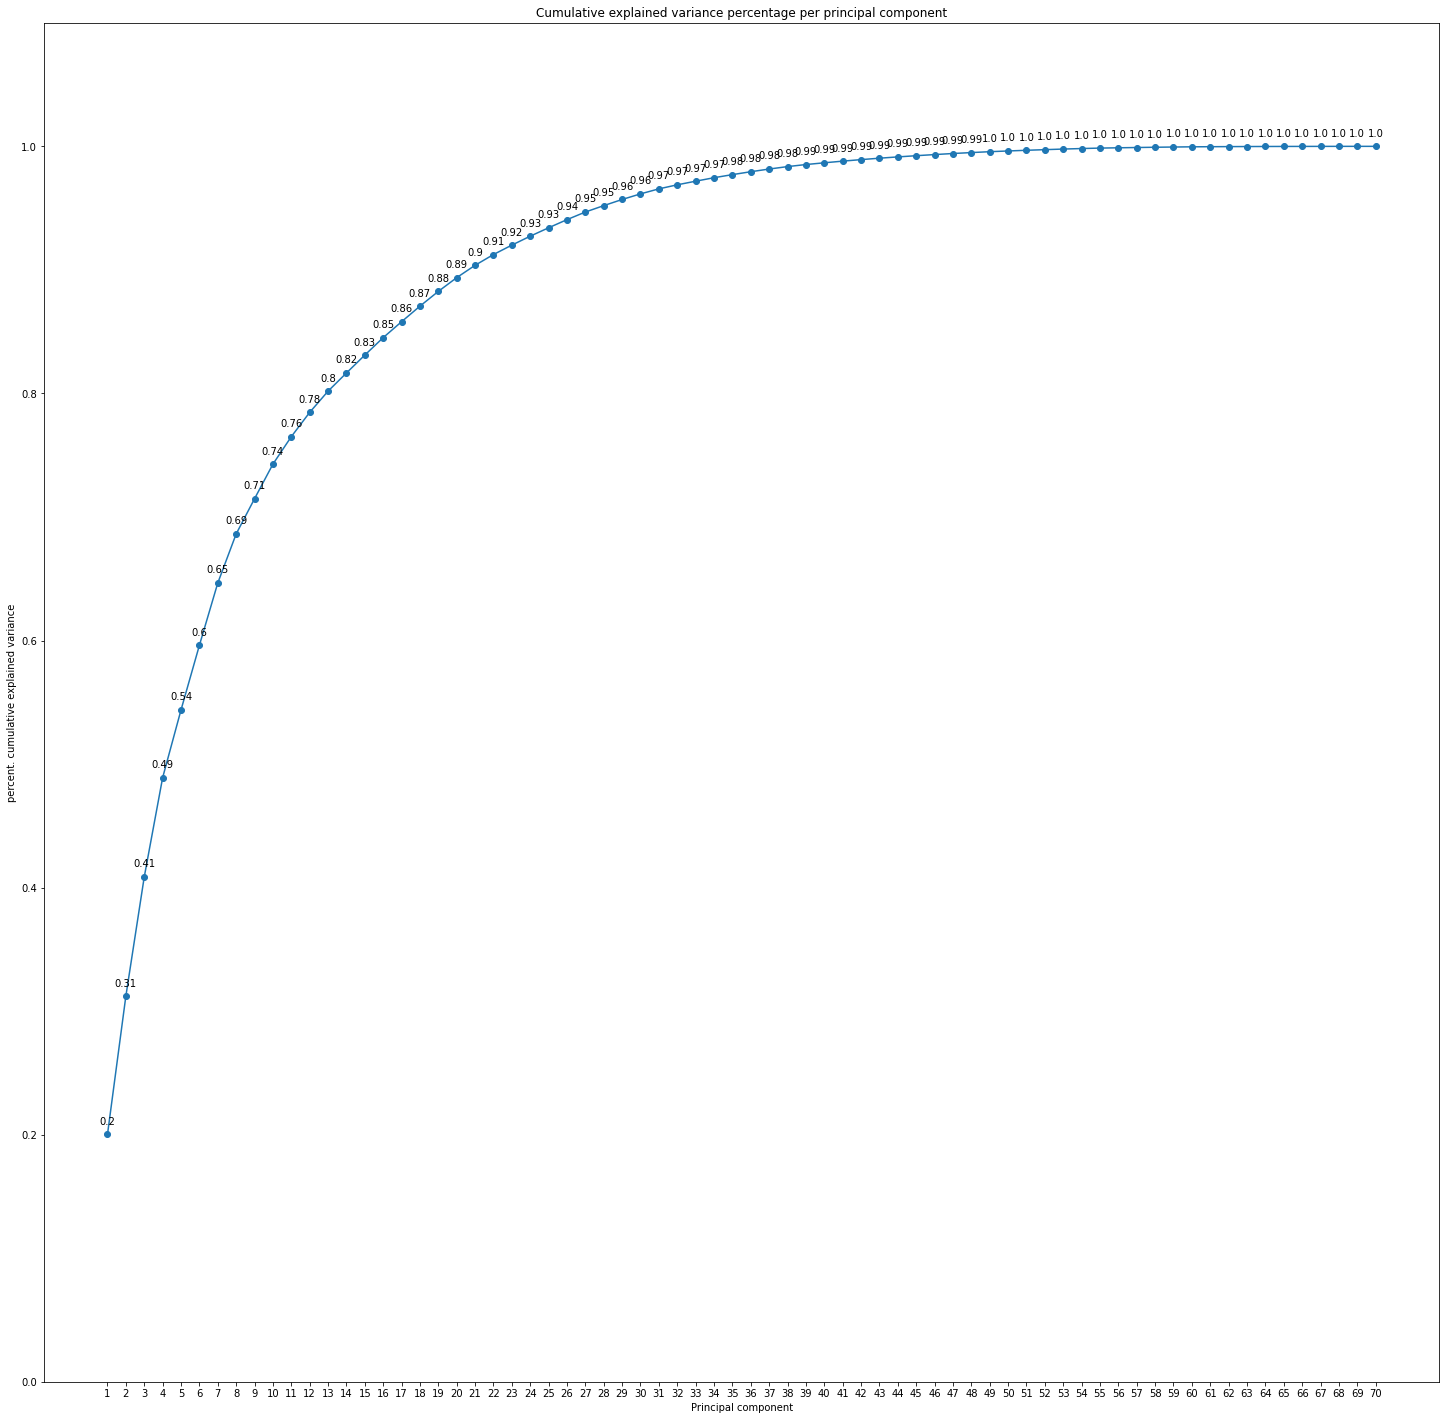

In [43]:
fig, ax = plot_explained_variance(full_experiments_summary_train.loc[:, full_experiments_summary_train.columns != 'filename'], train_pca_model)
fig, ax = plot_explained_variance_ratio(full_experiments_summary_train.loc[:, full_experiments_summary_train.columns != 'filename'], train_pca_model)
# fig, ax = plot_variable_importance(full_experiments_summary_train.loc[:, full_experiments_summary_train.columns != 'filename'], train_pca_model)

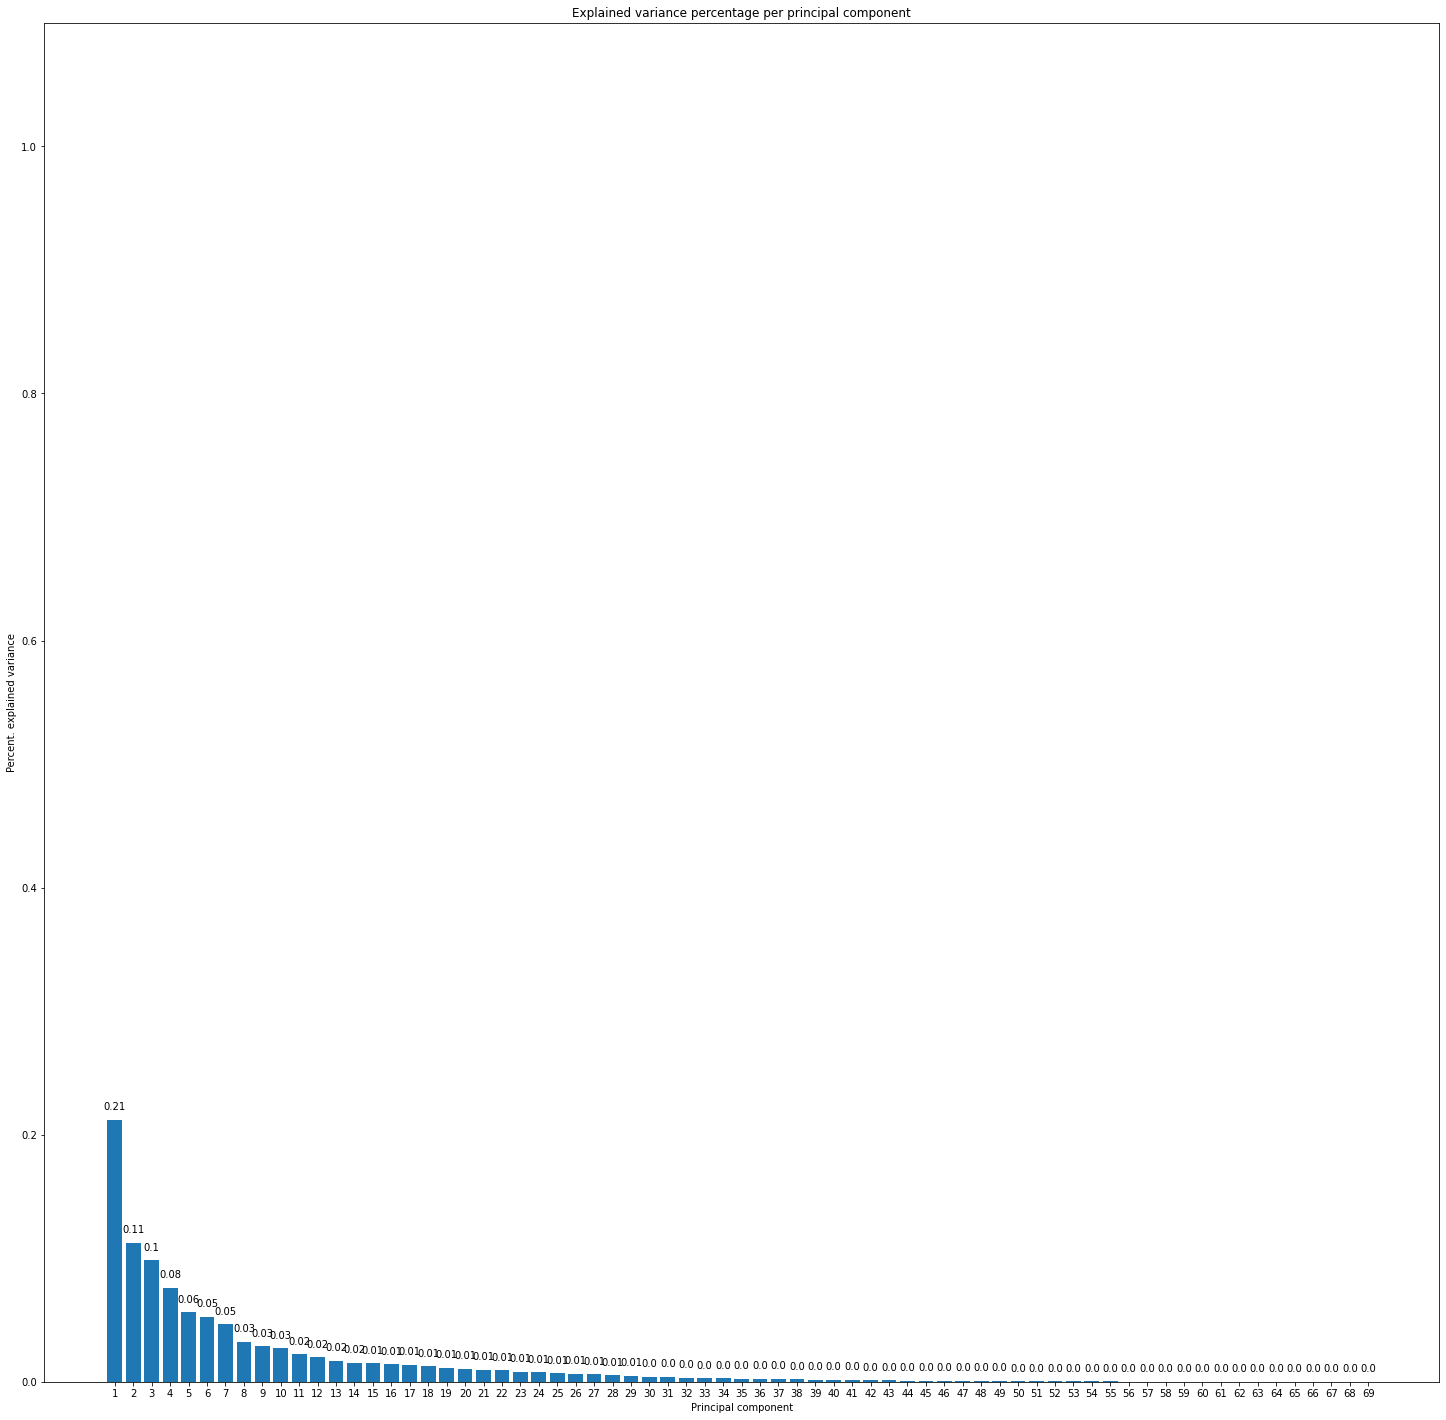

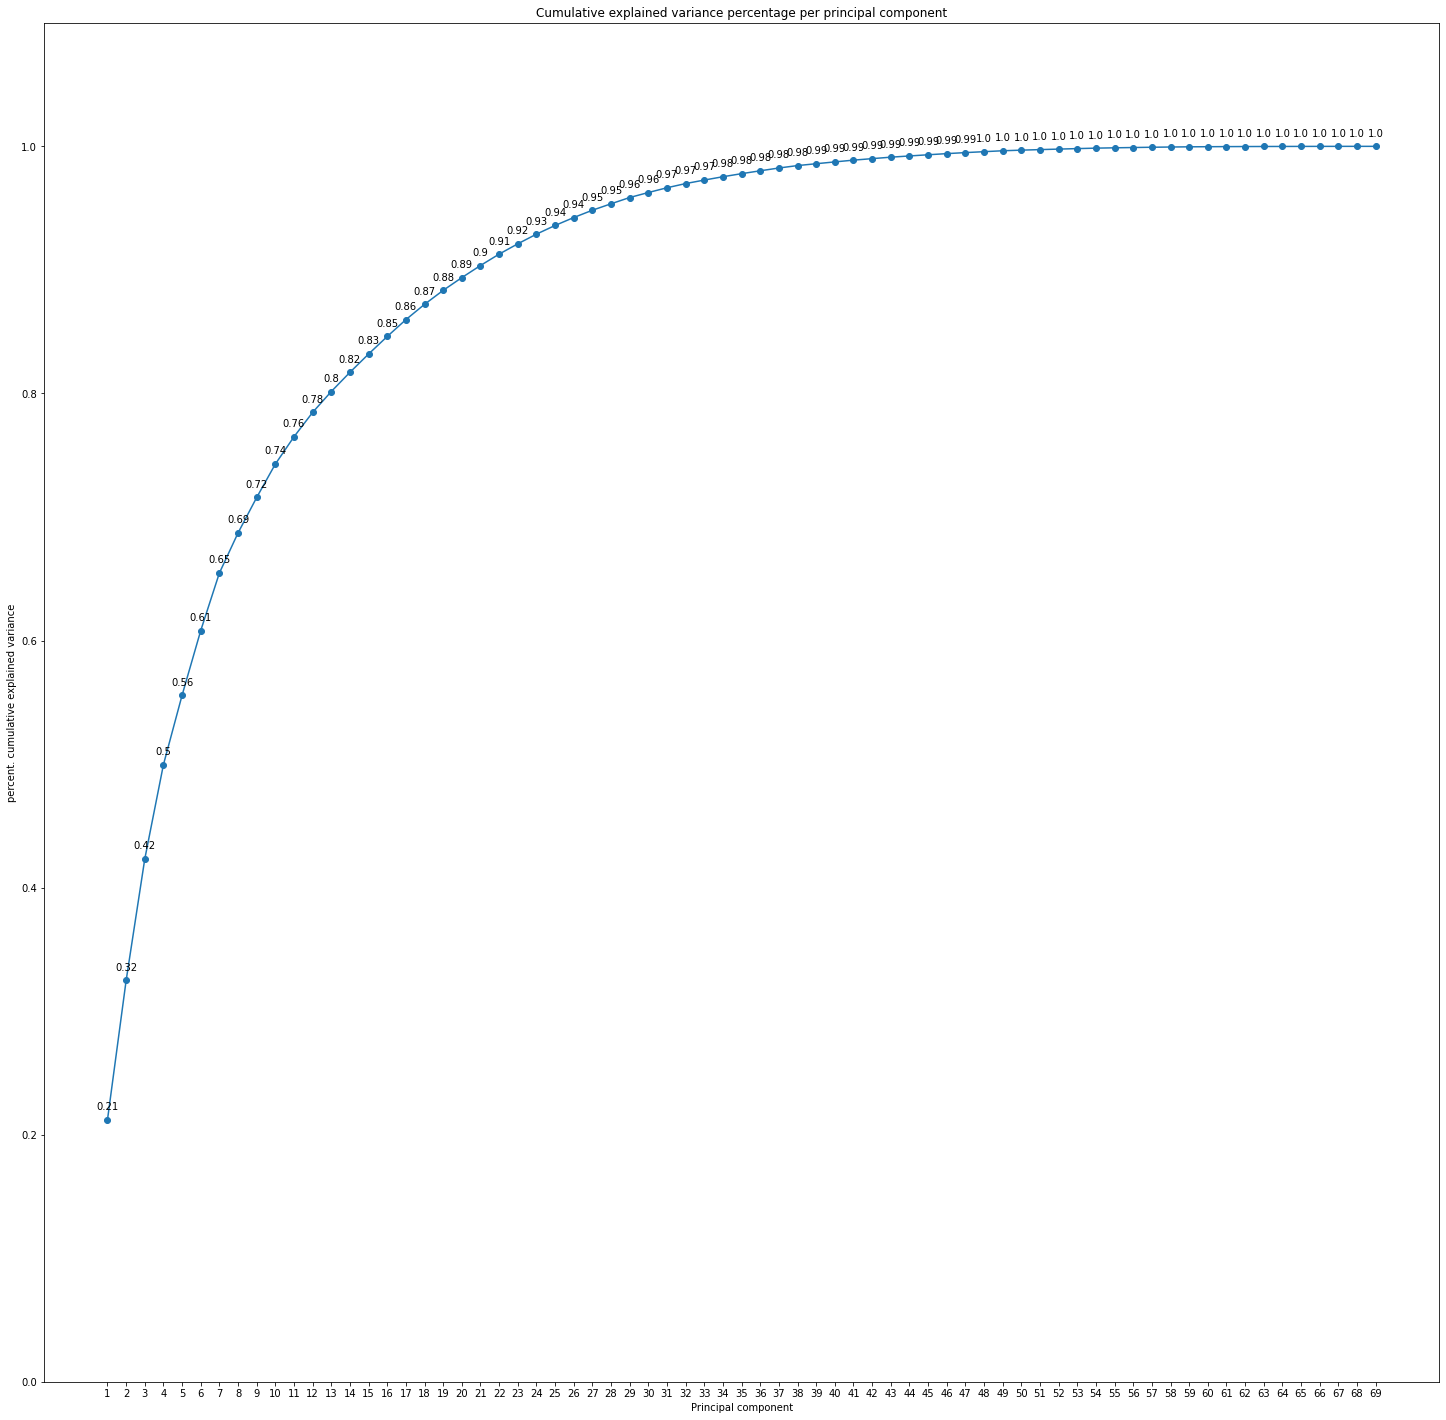

In [44]:
fig, ax = plot_explained_variance(full_experiments_summary_test.loc[:, full_experiments_summary_test.columns != 'filename'], test_pca_model)
fig, ax = plot_explained_variance_ratio(full_experiments_summary_test.loc[:, full_experiments_summary_test.columns != 'filename'], test_pca_model)
# fig, ax = plot_variable_importance(full_experiments_summary_test.loc[:, full_experiments_summary_test.columns != 'filename'], test_pca_model)

Podemos ver que ninguna de las componentes principales consigue explicar una varianza por encima del 20% para ambos datasets. Así, podemos decir que no se puede realizar una reducción de la dimensionalidad de las estadísticas puesto que existe una muy baja correlación entre sí. Esto ultimo se puede ver en el peso de las distintas variables en cada componente. Es en muy pocas componentes en las que varias variables tienen un peso elevado.  

# Planteamiento como problema de aprendizaje por refuerzo (reinforcement learning)

Un problema de aprendizaje por refuerzo cuenta con los siguientes elementos:

- Estado: Situación del agente. En el problema se representa por las variables:
    - x_pos, y_pos
    - x_vel, y_vel
    - angle, angle_vel
    - leg1, leg2

- Acciones: Acciones que puede realizar el agente. En el problema se representan por las variables:
    - main_booster
    - lat_booster


- Entorno: Entorno en el que se encuentra el agente. En el problema se representa por las variables:
    - gravity
    - wind_power
    - turbulences

# Preprocessing

## Impute missing values in experiments summary

In [62]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, SimpleImputer, IterativeImputer

In [46]:
def impute_summary_only(experiments_summary, imputer=KNNImputer(n_neighbors=15)):
    experiments_summary_knn = experiments_summary[['total_timesteps', 'gravity', 'wind_power', 'turbulence_power']].copy()

    experiments_summary_knn.loc[experiments_summary_knn['gravity'] == 0, 'gravity'] = np.nan
    experiments_summary_knn.loc[experiments_summary_knn['wind_power'] == 0, 'wind_power'] = np.nan

    imputed_series = imputer.fit_transform(experiments_summary_knn.values)
    imputed_series = pd.DataFrame(imputed_series, columns=experiments_summary_knn.columns)
    imputed_series = imputed_series.set_index(experiments_summary_knn.index)

    experiments_summary_copy = experiments_summary.copy()
    experiments_summary_copy[['total_timesteps', 'gravity', 'wind_power', 'turbulence_power']] = imputed_series

    return experiments_summary_copy

In [47]:
# experiments_summary_train_imputed = impute_summary_only(experiments_summary_train)
# experiments_summary_test_imputed = impute_summary_only(experiments_summary_test)
experiments_summary_train_imputed = impute_summary_only(full_experiments_summary_train, IterativeImputer())
experiments_summary_test_imputed = impute_summary_only(full_experiments_summary_test, IterativeImputer())

In [48]:
print(get_nans_experiments_summary(experiments_summary_train_imputed))
print(get_nans_experiments_summary(experiments_summary_test_imputed))

(0, 0, 0)
(0, 0, 0)


In [49]:
experiments_summary_train_imputed.to_excel('data/experiments_summary_train_imputed.xlsx')
experiments_summary_test_imputed.to_excel('data/experiments_summary_test_imputed.xlsx')  

Para verificar la efectividad de la imputación mediante KNN se seleccionarán filas que carezcan de valores nulos y posteriormente se aplicará la imputación por KNN. Tras ello, se calculará el MAE con respecto a su verdadero valor.

In [75]:
def get_error_imputed(experiments_summary_train, imputer=IterativeImputer(), error_function=None):
    experiments_summary_train_copy = experiments_summary_train.copy()
    experiments_summary_train_copy.drop(columns=['filename'], inplace=True)

    indexes_no_missing = experiments_summary_train_copy[(experiments_summary_train_copy['gravity'] != 0) & (experiments_summary_train_copy['wind_power'] != 0)].index

    gravity_nans, wind_power_nans, gravity_wind_power_nans = get_nans_experiments_summary(experiments_summary_train_copy)
    gravity_nans_percent, wind_power_nans_percent, gravity_wind_power_nans_percent = gravity_nans/experiments_summary_train_copy.shape[0], wind_power_nans/experiments_summary_train_copy.shape[0], gravity_wind_power_nans/experiments_summary_train_copy.shape[0]


    indexes_gravity_nans = np.random.choice(indexes_no_missing, int(len(indexes_no_missing) * gravity_nans_percent), replace=False)
    indexes_no_missing = np.setdiff1d(indexes_no_missing, indexes_gravity_nans)

    indexes_wind_power_nans = np.random.choice(indexes_no_missing, int(len(indexes_no_missing) * wind_power_nans_percent), replace=False)
    indexes_no_missing = np.setdiff1d(indexes_no_missing, indexes_wind_power_nans)

    indexes_gravity_wind_power_nans = np.random.choice(indexes_no_missing, int(len(indexes_no_missing) * gravity_wind_power_nans_percent), replace=False)
    indexes_no_missing = np.setdiff1d(indexes_no_missing, indexes_gravity_wind_power_nans)


    experiments_summary_train_copy.loc[indexes_gravity_nans, 'gravity'] = np.nan
    experiments_summary_train_copy.loc[indexes_wind_power_nans, 'wind_power'] = np.nan
    experiments_summary_train_copy.loc[indexes_gravity_wind_power_nans, ['gravity', 'wind_power']] = np.nan


    imputed_series = imputer.fit_transform(experiments_summary_train_copy.values)
    imputed_series = pd.DataFrame(imputed_series, columns=experiments_summary_train_copy.columns)
    imputed_series = imputed_series.set_index(experiments_summary_train_copy.index)

    if error_function == 'rmse':
        rmse_gravity = np.sqrt(np.mean((imputed_series.loc[indexes_gravity_nans, 'gravity'] - experiments_summary_train.loc[indexes_gravity_nans, 'gravity'])**2))
        rmse_wind_power = np.sqrt(np.mean((imputed_series.loc[indexes_wind_power_nans, 'wind_power'] - experiments_summary_train.loc[indexes_wind_power_nans, 'wind_power'])**2))
        rmse_gravity_wind_power = np.sqrt(np.mean((imputed_series.loc[indexes_gravity_wind_power_nans, ['gravity', 'wind_power']] - experiments_summary_train.loc[indexes_gravity_wind_power_nans, ['gravity', 'wind_power']])**2))
        rmse_total = np.sqrt(np.mean((imputed_series.loc[:, ['gravity', 'wind_power']] - experiments_summary_train.loc[:, ['gravity', 'wind_power']])**2))

        return rmse_gravity, rmse_wind_power, rmse_gravity_wind_power.values, rmse_total.values

    elif error_function == 'mae':
        mae_knn_imputed_gravity_nans = np.mean(np.abs(imputed_series.loc[indexes_gravity_nans, 'gravity'] - experiments_summary_train.loc[indexes_gravity_nans, 'gravity']))
        mae_knn_imputed_wind_power_nans = np.mean(np.abs(imputed_series.loc[indexes_wind_power_nans, 'wind_power'] - experiments_summary_train.loc[indexes_wind_power_nans, 'wind_power']))
        mae_knn_imputed_gravity_wind_power_nans = np.mean(np.abs(imputed_series.loc[indexes_gravity_wind_power_nans, ['gravity', 'wind_power']] - experiments_summary_train.loc[indexes_gravity_wind_power_nans, ['gravity', 'wind_power']])).values
        mae_knn_imputed = np.mean(np.abs(imputed_series[['gravity', 'wind_power']] - experiments_summary_train[['gravity', 'wind_power']])).values

        return mae_knn_imputed_gravity_nans, mae_knn_imputed_wind_power_nans, mae_knn_imputed_gravity_wind_power_nans, mae_knn_imputed
        
    else:
        raise ValueError('error_function must be either rmse or mae')

In [79]:
imputers = [KNNImputer(n_neighbors=15), SimpleImputer(strategy='median'), SimpleImputer(strategy='mean'), IterativeImputer()]

for imputer in imputers:
    print(imputer)

    rmse_gravity, rmse_wind_power, rmse_gravity_wind_power, rmse_total = get_error_imputed(full_experiments_summary_train, error_function='rmse', imputer=imputer)
    print('RMSE:', rmse_gravity, rmse_wind_power, rmse_gravity_wind_power, rmse_total)

    mae_gravity_nans, mae_wind_power_nans, mae_gravity_wind_power_nans, mae_total = get_error_imputed(full_experiments_summary_train, error_function='mae', imputer=imputer)
    print('MAE:', mae_gravity_nans, mae_wind_power_nans, mae_gravity_wind_power_nans, mae_total)

    print()

KNNImputer(n_neighbors=15)
RMSE: 1.726269769600021 5.094776152158107 [1.94472612 4.72437436] [0.60797987 1.36720634]
MAE: 1.3620387710909652 4.128821886302049 [1.51026713 4.1053463 ] [0.16715702 0.30188468]

SimpleImputer(strategy='median')
RMSE: 3.2460319316467445 5.833126083693227 [3.30331829 6.02233574] [1.13437201 1.5836007 ]
MAE: 2.8483305221415356 5.002063590566343 [3.03423852 4.39622283] [0.34854577 0.3609987 ]

SimpleImputer()
RMSE: 3.3121839195498635 5.933133363935353 [3.36153897 6.32870172] [1.15727279 1.61717669]
MAE: 2.621429301712616 5.017947656575135 [2.49986621 4.8713399 ] [0.3183806  0.36592622]

IterativeImputer()
RMSE: 1.4598237519253423 4.704833747912525 [1.4167354  4.53880389] [0.50854779 1.2676411 ]
MAE: 1.2170769416507137 3.8590160481405844 [1.12824691 3.22476445] [0.14755213 0.27713692]



In [90]:
indexes_no_zeros = np.where(full_experiments_summary_train.loc[:, ['gravity', 'wind_power']] != 0)[0]

gravity_range = np.max(full_experiments_summary_train.loc[indexes_no_zeros, 'gravity']) - np.min(full_experiments_summary_train.loc[indexes_no_zeros, 'gravity'])
wind_power_range = np.max(full_experiments_summary_train.loc[indexes_no_zeros, 'wind_power']) - np.min(full_experiments_summary_train.loc[indexes_no_zeros, 'wind_power'])
gravity_range, wind_power_range

(11.98990727, 19.99615834)

## Adding static fields to time series

In [52]:
def mkdir_p(path):
    try:
        os.makedirs(path)
    except OSError as exc: # Python >2.5
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else: raise

def safe_open_w(path):
    mkdir_p(os.path.dirname(path))
    return open(path, 'w')

In [53]:
train_series_path = 'data/train'
test_series_path = 'data/test'
# train_experiments_summary_path = 'data/experiments_summary_train.xlsx'
# test_experiments_summary_path = 'data/experiments_summary_test.xlsx'
train_experiments_summary_path = 'data/experiments_summary_train_imputed.xlsx'
test_experiments_summary_path = 'data/experiments_summary_test_imputed.xlsx'

In [54]:
# Now that we have added the static variables (gravity, wind_power, turbulence_power)
# Create a numpy array of shape (samples, timesteps, features) from several csv files and assign each to the target variable (efficiency)
# - Load the data from the csv files
# - Create a numpy array of shape (samples, timesteps, features)
# - Assign each numpy array to a target variable
# - Return the target variable
def transform_data(series_path, experiments_summary_path, target_variable=None):
    experiments_summary = pd.read_excel(experiments_summary_path)
    experiments_summary = experiments_summary.set_index('filename')

    X = []
    y = []
    for filename in os.listdir(series_path):
        series_file = os.path.join(series_path, filename)
        experiment_series = pd.read_csv(series_file)
        
        experiment_summary = experiments_summary.loc[filename]
        
        # Preprocessing steps
        # - Add static fields
        # - Remove NaNs
        # for static_var in ['gravity', 'wind_power', 'turbulence_power']:
        #    experiment_series[static_var] = np.repeat(experiment_summary[static_var], experiment_summary['total_timesteps']+1)
        
        # KNN imputation on NaNs
        # - Create a KNN imputer
        # - Fit the imputer on the data
        # - Transform the data
        # - Return the transformed data
        imputer = KNNImputer(n_neighbors=5)
        imputed_series = imputer.fit_transform(experiment_series.values)
        imputed_series = pd.DataFrame(imputed_series, columns=experiment_series.columns)
        imputed_series = imputed_series.set_index(experiment_series.index)
        
        # X.append(experiment_series.values)
        X.append(imputed_series.values)

        if target_variable is not None:
            y.append(experiment_summary[target_variable])
    
    if target_variable is not None:
        return np.array(X), np.array(y)
    else:
        return np.array(X)

train_X, train_y = transform_data(train_series_path, train_experiments_summary_path, 'efficiency')
test_X = transform_data(test_series_path, test_experiments_summary_path)

# Dump the data to a numpy files
np.save('data/train_X.npy', train_X)
np.save('data/train_y.npy', train_y)
np.save('data/test_X.npy', test_X)

In [55]:
# Load the data from the numpy files and transform it to (samples, timesteps, features)
train_X, train_y = np.load('data/train_X.npy', allow_pickle=True), np.load('data/train_y.npy', allow_pickle=True)
test_X = np.load('data/test_X.npy', allow_pickle=True)

In [56]:
print(train_X.dtype)
print(train_y.dtype)
print(test_X.dtype)

print(train_X.shape, train_y.shape)
print(train_X[0].shape, train_y[0].shape)
print(train_X[0], train_y[0])

# Check nans in numpy arrays
print(pd.isnull(train_X).sum())
print(pd.isnull(train_y).sum())
print(pd.isnull(test_X).sum())

object
float64
object
(9513,) (9513,)
(997, 10) ()
[[-1.46112440e-03  1.40347648e+00 -1.48640588e-01 ...  0.00000000e+00
  -3.65657568e-01  8.22419524e-01]
 [-2.78825755e-03  1.39590454e+00 -1.33715481e-01 ...  0.00000000e+00
  -4.19537306e-01  7.35564113e-01]
 [-3.97968292e-03  1.38817918e+00 -1.18929170e-01 ...  0.00000000e+00
  -1.51419044e-01 -2.46148586e-01]
 ...
 [ 5.63264862e-02 -4.01928439e-04 -1.15629586e-08 ...  1.00000000e+00
  -7.79529929e-01  1.83593750e-01]
 [ 5.63264862e-02 -4.01928439e-04 -1.13901946e-08 ...  1.00000000e+00
  -8.82459402e-01  1.37330413e-01]
 [ 5.63264862e-02 -4.01928439e-04  0.00000000e+00 ...  1.00000000e+00
  -8.82459402e-01  1.37330413e-01]] 363.02
0
0
0


In [57]:
from sklearn.preprocessing import RobustScaler, StandardScaler

# Normalize the data with RobustScaler
scaler = StandardScaler() # RobustScaler()
_ = scaler.fit(np.concatenate(train_X, axis=0))

# For each time series in the training set with shape (samples, timesteps, features) normalize the data with the scaler
for i in range(train_X.shape[0]):
    train_X[i] = scaler.transform(train_X[i])

for i in range(test_X.shape[0]):
    test_X[i] = scaler.transform(test_X[i])

In [58]:
# Pad the data to make it of the same length (max of all samples)
def pad_data(X):
    max_length = max([x.shape[0] for x in X])
    X_padded = []
    for x in X:
        x_padded = np.zeros((max_length, x.shape[1]))
        x_padded[:x.shape[0], :] = x
        X_padded.append(x_padded)
    return np.array(X_padded)

train_X = pad_data(train_X)
test_X = pad_data(test_X)

print(train_X.shape, train_y.shape)
print(train_X[0].shape, train_y[0].shape)
print(test_X.shape)

(9513, 997, 10) (9513,)
(997, 10) ()
(2000, 952, 10)


In [59]:
def reshape_data_lstm(X):
    return X.reshape((X.shape[0], X[0].shape[0], X[0].shape[1]))

train_X = reshape_data_lstm(train_X)
test_X = reshape_data_lstm(test_X)

print(train_X.shape, train_y.shape)
print(train_X[0].shape, train_y[0].shape)
print(test_X.shape)

(9513, 997, 10) (9513,)
(997, 10) ()
(2000, 952, 10)


In [60]:
train_X_static = pd.read_excel(train_experiments_summary_path)
train_X_static = train_X_static.drop(['filename', 'efficiency'], axis=1).values

test_X_static = pd.read_excel(test_experiments_summary_path)
test_X_static = test_X_static.drop(['filename'], axis=1).values

print(train_X_static.shape, test_X_static.shape)

(9513, 70) (2000, 70)


In [61]:
# Use RobustScaler to normalize the static data
scaler = StandardScaler() # RobustScaler()
_ = scaler.fit(train_X_static)

train_X_static = scaler.transform(train_X_static)
test_X_static = scaler.transform(test_X_static)

In [62]:
print(train_X_static)

[[-1.73186875 -0.33773289  0.42841358 ...  0.43406581 -0.53009811
  -0.04341319]
 [-1.7315046   1.7238984   0.90187261 ... -1.53225232  1.54116861
  -0.04340924]
 [-1.73114046 -0.26986026  1.00810384 ...  0.43406581 -0.51237067
  -0.0433351 ]
 ...
 [ 1.73114046 -0.21895578  0.36533627 ...  0.43406581 -0.47537305
  -0.04339454]
 [ 1.7315046  -0.93161845 -0.05880878 ... -3.49857046 -0.52896785
  -0.04320232]
 [ 1.73186875 -1.11826819 -0.79143379 ...  0.43406581 -0.54148417
  -0.04173669]]


## Scaling and imputing

# LSTM

Crearemos una red LSTM que reciba series temporales asociadas a cada uno de los experimentos. Estas series contarán con todos las variables asociadas al estado y las acciones del agente, además de introducir como nuevas variables las del entorno. Estas últimas tendrán el mismo valor para todos los pasos del experimento.

Dado que las distintas series son de longitud variable y se encuentran en distintos archivos csv, deberemos entrenar la red mediante mini batches de tamano 1 (cada uno de los experimentos de los archivos). Otra opción sería realizar padding sobre las series, pero al contar con un rango amplio de timesteps para las series además de contar con gran cantidad de valores atípicos no parece un enfoque adecuado.

In [63]:
# !pip install livelossplot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [64]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import backend as K
from livelossplot import PlotLossesKeras

import time
import random

def reset_random_seeds():
   os.environ['PYTHONHASHSEED']=str(2)
   tf.random.set_seed(2)
   np.random.seed(2)
   random.seed(2)

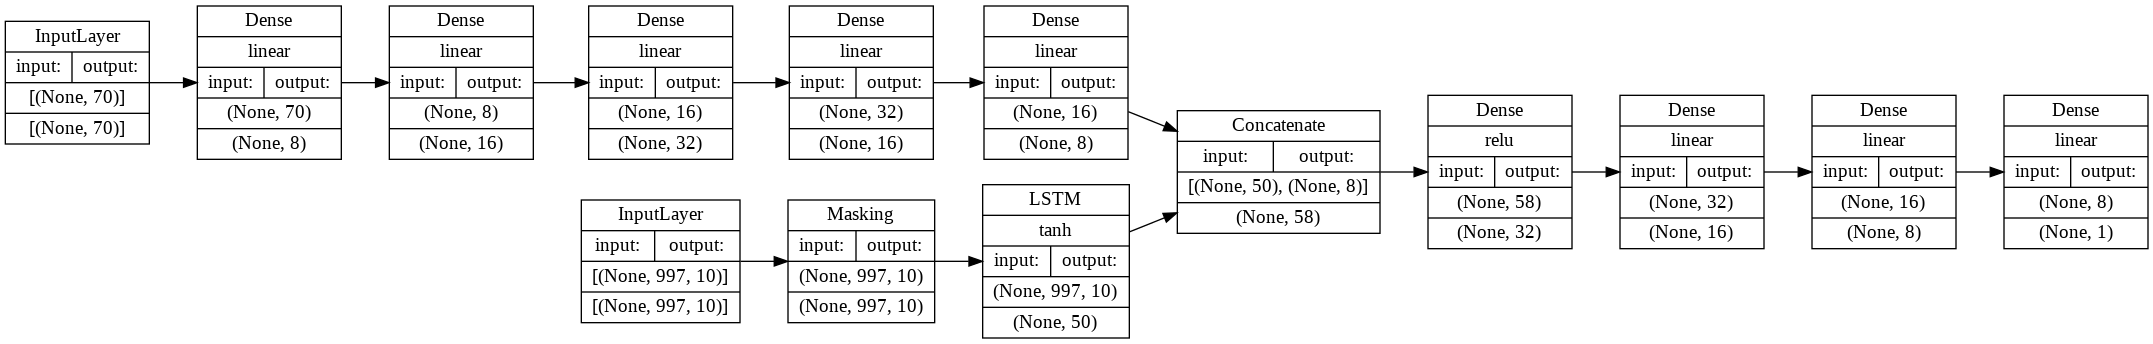

In [84]:
reset_random_seeds()

# def rmse(y_pred, y_true):
#     return K.sqrt(K.mean(K.square(y_pred - y_true)))

def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.math.squared_difference(y_true, y_pred)))

time_series_input_layer = keras.Input(shape=(train_X.shape[1], train_X.shape[2]))
static_input_layer = keras.Input(shape=(train_X_static.shape[1]))

masking_layer = layers.Masking(mask_value=0.,)(time_series_input_layer)
lstm_layer = layers.LSTM(50, activation='tanh', return_sequences=False)(masking_layer)

static_dense = layers.Dense(8)(static_input_layer)
static_dense = layers.Dense(16)(static_dense)
static_dense = layers.Dense(32)(static_dense)
static_dense = layers.Dense(16)(static_dense)
static_dense = layers.Dense(8)(static_dense)

# Concatenate the static input layer with the LSTM layer
concatenated_layer = layers.concatenate([lstm_layer, static_dense])

dense_layer = layers.Dense(32, activation='relu')(concatenated_layer)
dense_layer = layers.Dense(16)(dense_layer)
dense_layer = layers.Dense(8)(dense_layer)
dense_layer = layers.Dense(1)(dense_layer)

model = keras.Model(inputs=[time_series_input_layer, static_input_layer], outputs=dense_layer)
model.compile(loss=rmse, optimizer=keras.optimizers.Adam(learning_rate=0.003))

keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=False, show_layer_activations=True, rankdir='LR')

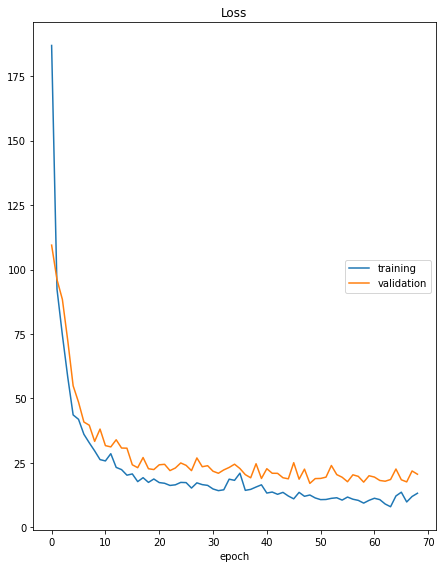

Loss
	training         	 (min:    7.985, max:  186.908, cur:   13.216)
	validation       	 (min:   17.045, max:  109.462, cur:   20.592)
119/119 - 4s - loss: 13.2159 - val_loss: 20.5924 - 4s/epoch - 37ms/step
Best val_loss for Early Stopping  epoch  49 :  17.044662475585938


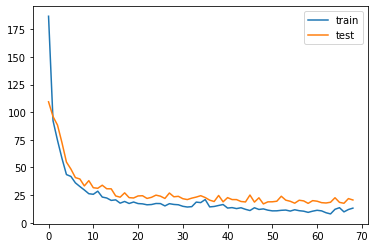

Time taken to train the model:  325.7394618988037


In [85]:
start_time = time.time()

# Train the model with early stopping.
history = model.fit(x=[train_X, train_X_static], y=train_y, epochs=500, batch_size=64, validation_split=0.2, verbose=2, shuffle=False, callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, min_delta=0.0001, restore_best_weights=True), PlotLossesKeras()])

print("Best val_loss for Early Stopping ", "epoch ", np.argmin(history.history['val_loss']) + 1, ": ", np.min(history.history['val_loss']))
# Plot the model's predictions
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

end_time = time.time()
print('Time taken to train the model: ', end_time - start_time)

In [67]:
# # Using keras tuner to find the best parameters for the model
# import keras_tuner as kt

# def model_builder(hp):
#     # Using previous model as the base model
#     time_series_input_layer = Input(shape=(train_X.shape[1], train_X.shape[2]))
#     static_input_layer = Input(shape=(train_X_static.shape[1]))

#     masking_layer = Masking(mask_value=0.,)(time_series_input_layer)
#     lstm_layer = LSTM(hp.Int('lstm_units', min_value=1, max_value=100), activation='tanh', return_sequences=False)(masking_layer)

#     static_dense = Dense(hp.Int('static_dense_units', min_value=1, max_value=16))(static_input_layer)

#     # Concatenate the static input layer with the LSTM layer
#     concatenated_layer = concatenate([lstm_layer, static_dense])

#     for _ in range(hp.Int('dense_layers', min_value=1, max_value=4)):
#         dense_layer = Dense(hp.Int('dense_units', min_value=1, max_value=50), activation=hp.Choice('dense_activation', ['relu', 'tanh', 'sigmoid', 'linear']))(concatenated_layer)
    
#     dense_layer = Dense(1, activation=hp.Choice('dense_activation', ['relu', 'tanh', 'sigmoid', 'linear']))(dense_layer)

#     model = Model(inputs=[time_series_input_layer, static_input_layer], outputs=dense_layer)
#     model.compile(loss='mean_absolute_error', optimizer='adam')
#     return model

# tuner = kt.tuners.Hyperband(model_builder, objective='val_loss', max_epochs=10, hyperband_iterations=10, random_state=2)
# stop_early = EarlyStopping(monitor='val_loss', patience=10, min_delta=0.0001, restore_best_weights=True)

# tuner.search(x=[train_X, train_X_static], y=train_y, epochs=500, batch_size=64, validation_split=0.2, verbose=2, shuffle=False, callbacks=[stop_early])

# # Get the best model
# best_model = tuner.get_best_models(num_models=1)[0]
# best_model.summary()

# # save the best model
# best_model.save('best_model.h5')
# # plot the best model
# plot_model(best_model, to_file='best_model_plot.png', show_shapes=True, show_layer_names=False, show_layer_activations=True, rankdir='LR')
# # save the best model hyperparameters
# with open('best_model_hyperparameters.txt', 'w') as f:
#     f.write(str(tuner.get_best_config(num_configs=1)))

In [68]:
# # Get the optimal hyperparameters
# best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

# print(f"""
# The hyperparameter search is complete. The optimal number of LSTM units is {best_hps.lstm_units}, the optimal number of static dense units is {best_hps.static_dense_units}, the optimal number of dense layers is {best_hps.dense_layers}, and the optimal number of dense units is {best_hps.dense_units}.
# """)